# Exploratory Data Analysis & Machine Learning Working Code
# _Factors affecting vessel delays at US Army Corps of Engineers-managed locks on US waterways._

## Springboard Data Science Career Track, Capstone 2
***
* Author: Heather A. Passmore
* Data: United States Army Corps of Engineers, Lock Performance Management System
* Capstone Description: [Project Proposal](https://github.com/PassMoreHeat/springboard/blob/master/Capstone_2/ProjectProposalCap2.md)
* Initial Data Approach: [Data Wrangling Report](https://github.com/PassMoreHeat/springboard/blob/master/Capstone_2/Data_Wrangling_Report.md)
* Milestone Report: [Predicting Vessel Delays for Corps of Engineers-Lock Performance Management System (LPMS) Data](https://github.com/PassMoreHeat/springboard/blob/master/Capstone_2/LPMS_Milestone_Report.md)
* Final Report: [Predicting Vessel Delays](https://github.com/PassMoreHeat/springboard/blob/master/Capstone_2/LPMS_Final_Report.md)
***
## Table of Contents
1. Import Modules & Dataframes
2. Create Dummies and Encode Focal Lock data for Machine Learning
3. Convert all categorical variables remaining to numerical with encoding 
4. Create feature matrix and target vector then split into testing and training
5. Fit Logistic Regression model
6. Fit Random Forest Model
7. Try Recusive Feature Elimination
8. Re-run Logistic Regression with reduced X_train
9. Re-run Random Forest with reduced X_train
10. Run models on individual locks

## 1. Import Modules & Dataframes

In [1]:
# import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
import pickle
import scipy.stats
from scipy.stats import norm
import scipy as sp

# Figures inline, visualization style
%matplotlib inline

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("talk")

In [2]:
# Import scikit-learn tools, vectorizers, transformer, and classifiers
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE

# import Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

# import Logistic Regression CV Classifier
from sklearn.linear_model import LogisticRegressionCV

In [3]:
# Bring ML_LPMS_final dataframe into workspace
# load the pickled ML_LPMS_final DataFrame from hard drive in 'rb' mode
with open('/Users/pgagnon/Documents/Springboard/springboard/Capstone_2/LockData/ML_LPMS_final.pickle','rb') as f:
    ML = pickle.load(f)

In [4]:
# sort ML df by E_R_L
ML_sort = ML.sort_values('E_R_L')
ML = ML_sort.reset_index(drop=True)

In [5]:
# Check ML contents
ML.head()

,E_R_L,YYMMDD,delay_cat,LOCKAGE_TYPE,VESSEL_FUNCTION_TYPE,assist,year,day_of_year,day_of_week,month,...,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,WSF2,WSF5,WT_count,WType
0,B2_FB_41,2017-06-16,0,O,F,0,2017,167,4,6,...,0.0,0.0,0.0,0.0,91.0,73.0,16.1,21.0,1,1
1,B2_FB_41,2015-12-07,1,S,K,0,2015,341,0,12,...,0.0,0.0,0.0,0.0,71.0,47.0,12.1,16.1,1,1
2,B2_FB_41,2013-04-06,0,S,K,0,2013,96,5,4,...,0.0,0.0,0.0,0.0,71.0,48.0,16.1,21.0,1,1
3,B2_FB_41,2016-10-30,1,S,K,0,2016,304,6,10,...,0.0,0.0,0.0,0.0,88.0,58.0,8.9,13.0,2,1
4,B2_FB_41,2013-04-27,1,S,K,0,2013,117,5,4,...,0.0,0.0,0.0,0.0,82.0,70.0,17.0,23.0,0,0


## 2. Create Dummies and Encode Focal Lock data for Machine Learning

In [6]:
#Define a generic function using Pandas replace function
def coding(col, codeDict):
  colCoded = pd.Series(col, copy=True)
  for key, value in codeDict.items():
    colCoded.replace(key, value, inplace=True)
  return colCoded

In [7]:
# Lump the rare and barge-related lockage types (A, B, T, V) into one category (X)
#Coding LOCKAGE_TYPE (A, B, T, V) as X:
print('Before Coding:')
print(pd.value_counts(ML['LOCKAGE_TYPE']))
ML['lockage'] = coding(ML['LOCKAGE_TYPE'], {'A':'X','B':'X','T':'X','V':'X'})
print('\nAfter Coding:')
print(pd.value_counts(ML['lockage']))

Before Coding:
S    9349
O    6070
C      53
K      47
N       9
B       5
V       3
A       1
T       1
Name: LOCKAGE_TYPE, dtype: int64

After Coding:
S    9349
O    6070
C      53
K      47
X      10
N       9
Name: lockage, dtype: int64


In [8]:
# Lump Dry Cargo (C) and Liquid Cargo (E): Y
# Lump Federal Gov. Ves (G), Government Nonfederal Ves (N), and Fed. Gov Contractor (U): X
# Lump Non-Cargo Vessel (M) with Other (Z): W
#Coding VESSEL_FUNCTION_TYPE:
print('Before Coding:')
print(pd.value_counts(ML['VESSEL_FUNCTION_TYPE']))
ML['VFT'] = coding(ML['VESSEL_FUNCTION_TYPE'], {'C':'Y','E':'Y','G':'X','N':'X','U':'X','M':'W','Z':'W'})
print('\nAfter Coding:')
print(pd.value_counts(ML['VFT']))

Before Coding:
T    12657
R      870
K      702
C      592
F      441
P      159
G       50
N       30
Z       15
E       14
M        5
U        3
Name: VESSEL_FUNCTION_TYPE, dtype: int64

After Coding:
T    12657
R      870
K      702
Y      606
F      441
P      159
X       83
W       20
Name: VFT, dtype: int64


In [9]:
# Encode all TIME variables. First: day_of_week (Monday=0, Sunday = 6) => weekday(1)/weekend(0) 
#Coding weekday where weekdays (0-4) = 1, weekend (5, 6) = 0
print('Before Coding:')
print(pd.value_counts(ML['day_of_week']))
ML['weekday'] = coding(ML['day_of_week'], {0:1,1:1,2:1,3:1,4:1,5:0,6:0})
print('\nAfter Coding:')
print(pd.value_counts(ML['weekday']))

Before Coding:
5    2433
6    2427
2    2220
1    2170
4    2135
3    2127
0    2026
Name: day_of_week, dtype: int64

After Coding:
1    10678
0     4860
Name: weekday, dtype: int64


In [10]:
# Encode all TIME variables. Second: month (1-12) to season (spring, summer, fall, winter)
#Coding season where spring (month 0-4) = 1, weekend (5, 6) = 0
print('Before Coding:')
print(pd.value_counts(ML['month']))
ML['season'] = coding(ML['month'], {1:'winter',2:'winter',3:'spring',4:'spring',5:'spring',6:'summer',
                                    7:'summer',8:'summer',9:'fall',10:'fall',11:'fall',12:'winter'})
print('\nAfter Coding:')
print(pd.value_counts(ML['season']))

Before Coding:
1     1347
10    1339
7     1337
8     1327
3     1323
5     1317
11    1302
12    1293
4     1264
6     1251
9     1250
2     1188
Name: month, dtype: int64

After Coding:
summer    3915
spring    3904
fall      3891
winter    3828
Name: season, dtype: int64


In [11]:
# Encode all TIME variables. Next: hour_of_day (0-24) to 'night' (1) or day=0
#Coding season where spring (month 0-4) = 1, weekend (5, 6) = 0
print('Before Coding:')
print(pd.value_counts(ML['hour_of_day']))
ML['night'] = coding(ML['hour_of_day'], {0:1, 1:1, 2:1, 3:1, 4:1, 5:1, 6:0,
                                    7:0, 8:0, 9:0, 10:0, 11:0, 12:0, 13:0, 14:0, 15:0, 16:0,
                                    17:0, 18:1, 19:1, 20:1, 21:1, 22:1, 23:1})
print('\nAfter Coding:')
print(pd.value_counts(ML['night']))

Before Coding:
11    845
13    780
9     768
12    743
10    738
15    734
17    726
14    716
0     711
18    705
16    699
19    678
8     642
7     639
20    638
6     584
21    561
22    554
1     543
2     525
3     522
23    516
5     486
4     485
Name: hour_of_day, dtype: int64

After Coding:
0    8614
1    6924
Name: night, dtype: int64


In [12]:
# Identify US holidays over the 5-year period (True/False)
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
dr = pd.date_range(start='2013-01-01', end='2017-12-31')

cal = calendar()
holidays = cal.holidays(start=dr.min(), end=dr.max())

ML['US_hol'] = ML['YYMMDD'].isin(holidays)
ML.US_hol.value_counts()

False    15080
True       458
Name: US_hol, dtype: int64

In [13]:
# Coding 'holiday' as False=0, True=1:
print('Before Coding:')
print(pd.value_counts(ML['US_hol']))
ML['holiday'] = coding(ML['US_hol'], {False:'0', True:'1'})
print('\nAfter Coding:')
print(pd.value_counts(ML['holiday']))

Before Coding:
False    15080
True       458
Name: US_hol, dtype: int64

After Coding:
0    15080
1      458
Name: holiday, dtype: int64


In [14]:
# Number of observations
ML.shape[0]

15538

In [15]:
# Number of features
ML.shape[1]

34

In [16]:
# Get list of columns to remove unneccesary ones
ML_cols = list(ML.columns.values)
print(ML_cols)

['E_R_L', 'YYMMDD', 'delay_cat', 'LOCKAGE_TYPE', 'VESSEL_FUNCTION_TYPE', 'assist', 'year', 'day_of_year', 'day_of_week', 'month', 'hour_of_day', 'entry_time', 'exit_time', 'delay_time', 'unplan_max_stop', 'AWND', 'PGTM', 'PRCP', 'SNOW', 'SNWD', 'TAVG', 'TMAX', 'TMIN', 'WSF2', 'WSF5', 'WT_count', 'WType', 'lockage', 'VFT', 'weekday', 'season', 'night', 'US_hol', 'holiday']


## 3. Convert all categorical variables remaining to numerical with encoding

In [17]:
# drop 'YYMMDD', 'delay_time', 'entry_time', 'exit_time', 'WT_count' and time columns no longer needed
ML.drop(['YYMMDD', 'LOCKAGE_TYPE', 'VESSEL_FUNCTION_TYPE', 'delay_time', 'entry_time', 'exit_time', 'day_of_week',
        'month', 'day_of_year',  'month', 'hour_of_day', 'US_hol', 'WT_count'], axis=1, inplace=True)
ML.shape

(15538, 22)

In [18]:
# Check remaining columns
ML['holiday'] = ML['holiday'].astype(int)
ML.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15538 entries, 0 to 15537
Data columns (total 22 columns):
E_R_L              15538 non-null object
delay_cat          15538 non-null int64
assist             15538 non-null int64
year               15538 non-null int64
unplan_max_stop    15538 non-null float64
AWND               15538 non-null float64
PGTM               15538 non-null float64
PRCP               15538 non-null float64
SNOW               15538 non-null float64
SNWD               15538 non-null float64
TAVG               15538 non-null float64
TMAX               15538 non-null float64
TMIN               15538 non-null float64
WSF2               15538 non-null float64
WSF5               15538 non-null float64
WType              15538 non-null object
lockage            15538 non-null object
VFT                15538 non-null object
weekday            15538 non-null int64
season             15538 non-null object
night              15538 non-null int64
holiday            15538

In [19]:
# Use pd.get_dummies on catagorical vars 'E_R_L', 'lockage', 'VFT', 'year', 'season'
ML_LPMS = pd.get_dummies(data=ML, columns=['E_R_L', 'lockage', 'VFT', 'year', 'season'], drop_first = True)

In [20]:
# Number of observations
ML_LPMS.shape[0]

15538

In [21]:
# Number of features
ML_LPMS.shape[1]

45

In [22]:
ML_LPMS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15538 entries, 0 to 15537
Data columns (total 45 columns):
delay_cat          15538 non-null int64
assist             15538 non-null int64
unplan_max_stop    15538 non-null float64
AWND               15538 non-null float64
PGTM               15538 non-null float64
PRCP               15538 non-null float64
SNOW               15538 non-null float64
SNWD               15538 non-null float64
TAVG               15538 non-null float64
TMAX               15538 non-null float64
TMIN               15538 non-null float64
WSF2               15538 non-null float64
WSF5               15538 non-null float64
WType              15538 non-null object
weekday            15538 non-null int64
night              15538 non-null int64
holiday            15538 non-null int64
E_R_L_B2_GI_3      15538 non-null uint8
E_R_L_B2_GI_4      15538 non-null uint8
E_R_L_B2_GI_77     15538 non-null uint8
E_R_L_B3_MI_27     15538 non-null uint8
E_R_L_G3_WS_1      15538 non

## 4. Create feature matrix and target vector then split into testing and training

In [23]:
X = ML_LPMS.drop(['delay_cat'], axis=1)
y = ML_LPMS.delay_cat.values

In [24]:
X.shape

(15538, 44)

In [25]:
# Train Test Split
# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

# Show the results of the split
print("X Training set sample size:", (X_train.shape[0]))
print("X Testing set sample size:", (X_test.shape[0]))
print("y Training set sample size:", (y_train.shape[0]))
print("y Testing set sample size:", (y_test.shape[0]))

X Training set sample size: 11653
X Testing set sample size: 3885
y Training set sample size: 11653
y Testing set sample size: 3885


In [26]:
# Double check stratification
print(np.mean(y_train == 0))
print(np.mean(y_test == 0))

0.542864498412
0.542857142857


In [27]:
X_train.shape

(11653, 44)

In [28]:
# Scale continuous variables
# Import MinMaxScaler and initialize it
from sklearn.preprocessing import MinMaxScaler
min_max=MinMaxScaler()

# Scale down both train and test data set
X_train_minmax = min_max.fit_transform(X_train[['unplan_max_stop', 'AWND', 'PGTM', 'PRCP', 'SNOW', 'SNWD', 'TAVG', 
                                                'TMAX', 'TMIN', 'WSF2', 'WSF5']]) # , 'WT_count'
X_test_minmax = min_max.fit_transform(X_test[['unplan_max_stop', 'AWND', 'PGTM', 'PRCP', 'SNOW', 'SNWD', 'TAVG', 
                                              'TMAX', 'TMIN', 'WSF2', 'WSF5']]) # , 'WT_count'

In [29]:
# Standardize continuous variables
from sklearn.preprocessing import scale

# Scale both train and test data sets
X_train_scale=scale(X_train[['unplan_max_stop', 'AWND', 'PGTM', 'PRCP', 'SNOW', 'SNWD', 'TAVG', 
          'TMAX', 'TMIN', 'WSF2', 'WSF5']]) # , 'WT_count'
X_test_scale=scale(X_test[['unplan_max_stop', 'AWND', 'PGTM', 'PRCP', 'SNOW', 'SNWD', 'TAVG', 
          'TMAX', 'TMIN', 'WSF2', 'WSF5']]) # , 'WT_count'

## 5. Fit Logistic Regression model

In [30]:
# Fit Logistic Regression with Cross Validation
lgr=LogisticRegressionCV(scoring='roc_auc').fit(X_train,y_train)
print("training set score: %f" % lgr.score(X_train, y_train))
print('\n'"test set score: %f" % lgr.score(X_test, y_test))

training set score: 0.643010

test set score: 0.635264


In [31]:
# Fit Logistic Regression with Cross Validation: USE SCALED X_train_minmax
lgr=LogisticRegressionCV(scoring='roc_auc').fit(X_train_minmax,y_train)
print("training set score: %f" % lgr.score(X_train_minmax, y_train))
print('\n'"test set score: %f" % lgr.score(X_test_minmax, y_test))

training set score: 0.578134

test set score: 0.575032


In [32]:
# Fit Logistic Regression with Cross Validation: USE STANDARDIZED X_train_scale
lgr=LogisticRegressionCV(scoring='roc_auc').fit(X_train_scale,y_train)
print("training set score: %f" % lgr.score(X_train_scale, y_train))
print('\n'"test set score: %f" % lgr.score(X_test_scale, y_test))

training set score: 0.578306

test set score: 0.574260


### Note: Scaling and Standardizing did not improve training and testing scores, stick with Logistic Regression trained on X_train

training set score: 0.643010

test set score: 0.635264

Confusion Matrix:
 [[1511  598]
 [ 819  957]]


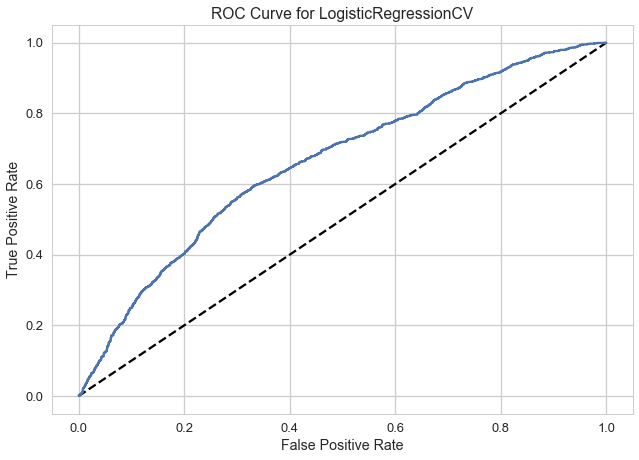


AUC score: 0.663090722301

parameters of current Logistic Regression CV model
 LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring='roc_auc', solver='lbfgs', tol=0.0001,
           verbose=0)


In [35]:
# Fit Logistic Regression with Cross Validation
lgr=LogisticRegressionCV(scoring='roc_auc').fit(X_train,y_train)
print("training set score: %f" % lgr.score(X_train, y_train))
print('\n'"test set score: %f" % lgr.score(X_test, y_test))

# calculated predicted class label per sample: pred_lgr
pred_lgr = lgr.predict(X_test)

# print the confusion matrix 
print('\n''Confusion Matrix:''\n', metrics.confusion_matrix(y_test, pred_lgr))

# calculate predicted probabilities for X_test Logistic Regression model
y_pred_prob_lgr = lgr.predict_proba(X_test)[:, 1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_lgr)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for LogisticRegressionCV')
plt.show()

# calculate AUC for LogisticRegressionCV classifier
print('\n''AUC score:', metrics.roc_auc_score(y_test, y_pred_prob_lgr))

# view paramaters of logistic regression CV
print('\n''parameters of current Logistic Regression CV model''\n',  lgr)

## 6. Fit Random Forest Model to Full Focal Lock Data

In [36]:
# Instantiate and fit the random forest model. 
rf = RandomForestClassifier().fit(X_train, y_train) 

## And score it on your testing data.
print("training set score: %f" % rf.score(X_train, y_train))
print('\n'"test set score: %f" % rf.score(X_test, y_test))
# This model is overfit

training set score: 0.981121

test set score: 0.651223


In [37]:
# Compare to Random Forest fit with scaled min/max X_train
# Instantiate and fit the random forest model. 
rf = RandomForestClassifier().fit(X_train_minmax, y_train) 

## And score it on your testing data.
print("training set score: %f" % rf.score(X_train_minmax, y_train))
print('\n'"test set score: %f" % rf.score(X_test_minmax, y_test))

training set score: 0.907063

test set score: 0.549292


In [38]:
# Compare to Random Forest fit with scaled continuous variables
# Instantiate and fit the random forest model. 
rf = RandomForestClassifier().fit(X_train_scale, y_train) 

## And score it on your testing data.
print("training set score: %f" % rf.score(X_train_scale, y_train))
print('\n'"test set score: %f" % rf.score(X_test_scale, y_test))

training set score: 0.908092

test set score: 0.551351


### Note: Scaling and Standardizing did not improve training and testing scores, stick with Random Forest trained on X_train


Confusion matrix:
 [[1613  496]
 [ 868  908]]


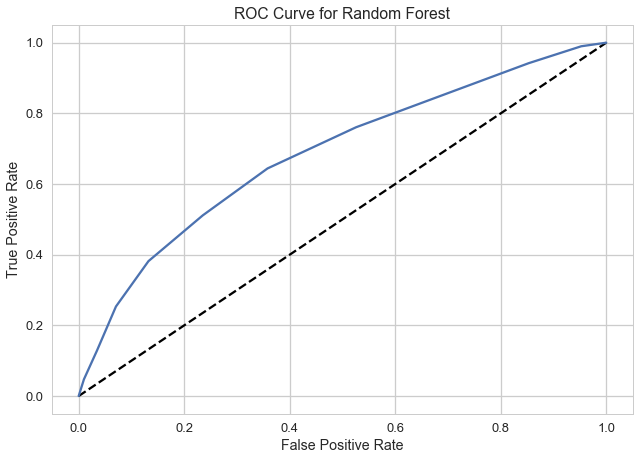

AUC Score for Random Forest Model 0.685544897671


In [39]:
# Re-fit the random forest model to X_train, y_train. 
rf = RandomForestClassifier().fit(X_train, y_train) 

# calculated predicted class label per sample: pred_rf
pred_rf = rf.predict(X_test)

# print the confusion matrix 
print('\n''Confusion matrix:''\n', metrics.confusion_matrix(y_test, pred_rf))

# calculate predicted probabilities
y_pred_prob_rf = rf.predict_proba(X_test)[:, 1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_rf)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest')
plt.show()

# calculate AUC for randomforest model
print('AUC Score for Random Forest Model', metrics.roc_auc_score(y_test, y_pred_prob_rf))

## Tune hyperparameters for Random Forest with GridSearchCV

In [40]:
# find best parameters with GridSearchCV
# create a list of performace parameters for performace tuning
params = {'max_features': [12, 15, 20, 24, 30, 35],
              'min_samples_leaf': [6, 8, 10, 12, 17, 22],
              'min_samples_split': [7, 8, 10, 12, 17, 22],
         }

In [41]:
# create an instance of the grid search by passing the classifier, parameters 
# and n_jobs=-1 which tells to use multiple cores from user machine.
gs_rf = GridSearchCV(RandomForestClassifier(), params, scoring='roc_auc', n_jobs=-1)
gs_rf = gs_rf.fit(X_train, y_train) 

# View the best AUC score
print('\n''Best score:', gs_rf.best_score_) 

# Get best parameters
print('\n''Best parameters:', gs_rf.best_params_)

# Explore feature importances
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
# Print sorted list of feature importances
feature_importances


Best score: 0.728030428003

Best parameters: {'max_features': 30, 'min_samples_leaf': 17, 'min_samples_split': 22}


,importance
AWND,0.119456
TMAX,0.114451
TMIN,0.111385
WSF5,0.097608
WSF2,0.089148
TAVG,0.058360
PRCP,0.049911
night,0.028361
weekday,0.023550
WType,0.021813


## 7. Try Recusive Feature Elimination

In [42]:
# feature extraction from LogisticRegressionCV
rfe = RFE(lgr, 15, step=1)
fit_lgr = rfe.fit(X_train, y_train)

mask = rfe.get_support(False)

print('Number of Features:', fit_lgr.n_features_)
print('Selected Features:',  fit_lgr.support_)
print('Feature Ranking:',  fit_lgr.ranking_)
print('Mask', mask)

Number of Features: 15
Selected Features: [False False False False False False False False False False False False
 False False False False  True  True False  True False  True  True  True
  True  True False  True  True  True False  True  True  True False  True
 False False False False False False False False]
Feature Ranking: [17 30 15 28 26 11  5 25 23 21 24 29 13 12 18 16  1  1  4  1 22  1  1  1  1
  1 27  1  1  1  2  1  1  1  9  1 19  8  7  6  3 14 20 10]
Mask [False False False False False False False False False False False False
 False False False False  True  True False  True False  True  True  True
  True  True False  True  True  True False  True  True  True False  True
 False False False False False False False False]


In [43]:
# Map the column names to the rankings to see what to keep (1's) and what to drop (ranked above 1)
print('Features sorted by their rank:')
print(sorted(zip(map(lambda x: round(x, 4), fit_lgr.ranking_), X_train.columns)))

Features sorted by their rank:
[(1, 'E_R_L_B2_GI_3'), (1, 'E_R_L_B2_GI_4'), (1, 'E_R_L_B3_MI_27'), (1, 'E_R_L_H2_OH_76'), (1, 'E_R_L_M3_GI_11'), (1, 'E_R_L_M3_GI_12'), (1, 'E_R_L_M3_GI_14'), (1, 'VFT_P'), (1, 'VFT_R'), (1, 'VFT_T'), (1, 'VFT_X'), (1, 'lockage_K'), (1, 'lockage_O'), (1, 'lockage_S'), (1, 'lockage_X'), (2, 'VFT_K'), (3, 'year_2017'), (4, 'E_R_L_B2_GI_77'), (5, 'SNWD'), (6, 'year_2016'), (7, 'year_2015'), (8, 'year_2014'), (9, 'VFT_W'), (10, 'season_winter'), (11, 'SNOW'), (12, 'weekday'), (13, 'WType'), (14, 'season_spring'), (15, 'AWND'), (16, 'holiday'), (17, 'assist'), (18, 'night'), (19, 'VFT_Y'), (20, 'season_summer'), (21, 'TMIN'), (22, 'E_R_L_G3_WS_1'), (23, 'TMAX'), (24, 'WSF2'), (25, 'TAVG'), (26, 'PRCP'), (27, 'lockage_N'), (28, 'PGTM'), (29, 'WSF5'), (30, 'unplan_max_stop')]


In [45]:
# Use the column names from 'mask' to subset X_train (update with 15)
X_train_rfe_lgr = X_train[['E_R_L_B2_GI_3', 'E_R_L_B2_GI_4', 'E_R_L_B3_MI_27', 'E_R_L_H2_OH_76', 'E_R_L_M3_GI_11', 
                           'E_R_L_M3_GI_12', 'E_R_L_M3_GI_14', 'VFT_P', 'VFT_R', 'VFT_T', 'VFT_X',
                           'lockage_K', 'lockage_O', 'lockage_S', 'lockage_X']]
X_train_rfe_lgr.shape

(11653, 15)

In [46]:
# Use the column names from 'mask' to subset X_test (update with 15)
X_test_rfe_lgr = X_test[['E_R_L_B2_GI_3', 'E_R_L_B2_GI_4', 'E_R_L_B3_MI_27', 'E_R_L_H2_OH_76', 'E_R_L_M3_GI_11', 
                           'E_R_L_M3_GI_12', 'E_R_L_M3_GI_14', 'VFT_P', 'VFT_R', 'VFT_T', 'VFT_X',
                           'lockage_K', 'lockage_O', 'lockage_S', 'lockage_X']]
X_test_rfe_lgr.shape

(3885, 15)

In [47]:
# feature extraction from RandomForest
rfe_rf = RFE(rf, 15, step=1)
fit_rf = rfe_rf.fit(X_train, y_train)

mask_rf = fit_rf.get_support(False)

print('Number of Features:', fit_rf.n_features_)
print('Selected Features:',  fit_rf.support_)
print('Feature Ranking:',  fit_rf.ranking_)
print('Random Forest Mask of features', mask_rf)

Number of Features: 15
Selected Features: [False  True  True False  True False False  True  True  True  True  True
  True  True  True False False False False False False False False False
 False False False False False False False False False  True False False
 False  True  True False False  True False False]
Feature Ranking: [21  1  1 22  1 24 25  1  1  1  1  1  1  1  1 18 13  9  3 17 11  7  6 12 15
 27 30 14  2 29 19 23 16  1 28 26 20  1  1  5  4  1  8 10]
Random Forest Mask of features [False  True  True False  True False False  True  True  True  True  True
  True  True  True False False False False False False False False False
 False False False False False False False False False  True False False
 False  True  True False False  True False False]


In [48]:
# Map the column names to the rankings to see what to keep (1's) and what to drop (ranked above 1)
print('Features sorted by their rank:')
print(sorted(zip(map(lambda x: round(x, 4), fit_rf.ranking_), X_train.columns)))

Features sorted by their rank:
[(1, 'AWND'), (1, 'PRCP'), (1, 'TAVG'), (1, 'TMAX'), (1, 'TMIN'), (1, 'VFT_T'), (1, 'WSF2'), (1, 'WSF5'), (1, 'WType'), (1, 'night'), (1, 'season_spring'), (1, 'unplan_max_stop'), (1, 'weekday'), (1, 'year_2014'), (1, 'year_2015'), (2, 'lockage_S'), (3, 'E_R_L_B2_GI_77'), (4, 'year_2017'), (5, 'year_2016'), (6, 'E_R_L_M3_GI_11'), (7, 'E_R_L_H2_OH_76'), (8, 'season_summer'), (9, 'E_R_L_B2_GI_4'), (10, 'season_winter'), (11, 'E_R_L_G3_WS_1'), (12, 'E_R_L_M3_GI_12'), (13, 'E_R_L_B2_GI_3'), (14, 'lockage_O'), (15, 'E_R_L_M3_GI_14'), (16, 'VFT_R'), (17, 'E_R_L_B3_MI_27'), (18, 'holiday'), (19, 'VFT_K'), (20, 'VFT_Y'), (21, 'assist'), (22, 'PGTM'), (23, 'VFT_P'), (24, 'SNOW'), (25, 'SNWD'), (26, 'VFT_X'), (27, 'lockage_K'), (28, 'VFT_W'), (29, 'lockage_X'), (30, 'lockage_N')]


In [49]:
# Use the top 15 variables to subset X_train for Random Forest
X_train_rfe_rf = X_train[['AWND', 'PRCP', 'TAVG', 'TMAX', 'TMIN', 'VFT_T', 'WSF2', 'WSF5', 'WType', 'night',
                         'season_spring', 'unplan_max_stop', 'weekday', 'year_2014', 'year_2015']]
X_train_rfe_rf.shape

(11653, 15)

In [51]:
# Use the top 15 variables to subset X_test for Random Forest
X_test_rfe_rf = X_test[['AWND', 'PRCP', 'TAVG', 'TMAX', 'TMIN', 'VFT_T', 'WSF2', 'WSF5', 'WType', 'night',
                         'season_spring', 'unplan_max_stop', 'weekday', 'year_2014', 'year_2015']]
X_test_rfe_rf.shape

(3885, 15)

## Re-run Logistic Regression with the reduced X_train

training set score: 0.623616

test set score: 0.620592

Confusion Matrix:
 [[1276  833]
 [ 641 1135]]


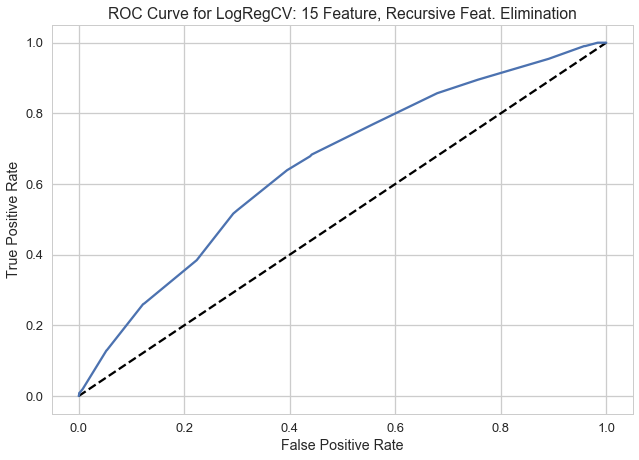


AUC Score: 0.652741201372


In [52]:
# Fit Logistic Regression with Cross Validation
lgr=LogisticRegressionCV(scoring='roc_auc').fit(X_train_rfe_lgr,y_train)
print("training set score: %f" % lgr.score(X_train_rfe_lgr, y_train))
print('\n'"test set score: %f" % lgr.score(X_test_rfe_lgr, y_test))

# calculated predicted class label per sample: pred_lgr
pred_lgr = lgr.predict(X_test_rfe_lgr)

# print the confusion matrix 
print('\n''Confusion Matrix:''\n', metrics.confusion_matrix(y_test, pred_lgr))

# calculate predicted probabilities for X_test Logistic Regression model
y_pred_prob_lgr = lgr.predict_proba(X_test_rfe_lgr)[:, 1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_lgr)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for LogRegCV: 15 Feature, Recursive Feat. Elimination')
plt.show()

# calculate AUC for LogisticRegressionCV classifier
print('\n''AUC Score:', metrics.roc_auc_score(y_test, y_pred_prob_lgr))

# RESULTS FOR 10 FEATURES: 
# training set score: 0.600189
# test set score: 0.589704

## Re-run Random Forest with the reduced X_train

training set score: 0.964129

test set score: 0.572201

Confusion Matrix:
 [[1464  645]
 [1017  759]]


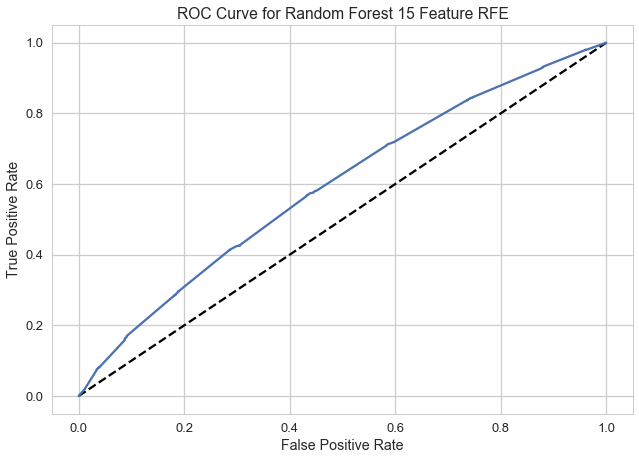


AUC Score: 0.593569654292


In [54]:
# Instantiate and fit the random forest model. 
rf = RandomForestClassifier().fit(X_train_rfe_rf, y_train) 

## And score it on your testing data.
print("training set score: %f" % rf.score(X_train_rfe_rf, y_train))
print('\n'"test set score: %f" % rf.score(X_test_rfe_rf, y_test))

# calculated predicted class label per sample: pred_rf
pred_rf = rf.predict(X_test_rfe_rf)

# print the confusion matrix 
print('\n' 'Confusion Matrix:''\n', metrics.confusion_matrix(y_test, pred_rf))

# calculate predicted probabilities
y_pred_prob_rf = rf.predict_proba(X_test_rfe_rf)[:, 1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_rf)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest 15 Feature RFE')
plt.show()

# calculate AUC for randomforest model (0.57 for 10 features)
print('\n''AUC Score:', metrics.roc_auc_score(y_test, y_pred_prob_rf))

# RESULTS FOR 10 FEATURES:
# training set score: 0.959495
# test set score: 0.557529

### Run grid search with RFE arrays

In [56]:
# find best parameters with GridSearchCV
# create a list of performace parameters for performace tuning
params_rfe = {'max_features': [3, 6, 12, 14],
              'min_samples_leaf': [6, 8, 10, 12, 17],
              'min_samples_split': [7, 8, 10, 12, 17],
         }

In [57]:
# create an instance of the grid search by passing the classifier, parameters 
# and n_jobs=-1 which tells to use multiple cores from user machine.
gs_rf = GridSearchCV(RandomForestClassifier(), params_rfe, scoring='roc_auc', n_jobs=-1)
gs_rf = gs_rf.fit(X_train_rfe_rf, y_train) 

# View the best AUC score
print('\n''Best score:', gs_rf.best_score_) 

# Get best parameters
print('\n''Best parameters:', gs_rf.best_params_)

# Explore feature importances
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_train_rfe_rf.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
# Print sorted list of feature importances
feature_importances


Best score: 0.637194401428

Best parameters: {'max_features': 3, 'min_samples_leaf': 17, 'min_samples_split': 7}


,importance
AWND,0.151825
TMIN,0.145141
TMAX,0.140149
WSF5,0.121591
WSF2,0.104688
TAVG,0.076714
PRCP,0.064610
night,0.036092
WType,0.026735
VFT_T,0.025726


## 10. Run models on individual locks

In [58]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11653 entries, 9681 to 4368
Data columns (total 44 columns):
assist             11653 non-null int64
unplan_max_stop    11653 non-null float64
AWND               11653 non-null float64
PGTM               11653 non-null float64
PRCP               11653 non-null float64
SNOW               11653 non-null float64
SNWD               11653 non-null float64
TAVG               11653 non-null float64
TMAX               11653 non-null float64
TMIN               11653 non-null float64
WSF2               11653 non-null float64
WSF5               11653 non-null float64
WType              11653 non-null object
weekday            11653 non-null int64
night              11653 non-null int64
holiday            11653 non-null int64
E_R_L_B2_GI_3      11653 non-null uint8
E_R_L_B2_GI_4      11653 non-null uint8
E_R_L_B2_GI_77     11653 non-null uint8
E_R_L_B3_MI_27     11653 non-null uint8
E_R_L_G3_WS_1      11653 non-null uint8
E_R_L_H2_OH_76     11653 n

In [59]:
X_train.E_R_L_B2_GI_3.value_counts()

0    11036
1      617
Name: E_R_L_B2_GI_3, dtype: int64

In [60]:
# Create indices (masks) for training dataframes for each lock
B2_GI_3_index = (X_train['E_R_L_B2_GI_3'] == 1)
B2_GI_4_index = (X_train['E_R_L_B2_GI_4'] == 1)
B2_GI_77_index = (X_train['E_R_L_B2_GI_77'] == 1)
B3_MI_27_index = (X_train['E_R_L_B3_MI_27'] == 1)
G3_WS_1_index = (X_train['E_R_L_G3_WS_1'] == 1)
H2_OH_76_index = (X_train['E_R_L_H2_OH_76'] == 1)
M3_GI_11_index = (X_train['E_R_L_M3_GI_11'] == 1)
M3_GI_12_index = (X_train['E_R_L_M3_GI_12'] == 1)
M3_GI_14_index = (X_train['E_R_L_M3_GI_14'] == 1)

In [61]:
# Create indices (masks) for testing dataframes for each lock
B2_GI_3_test_mask = (X_test['E_R_L_B2_GI_3'] == 1)
B2_GI_4_test_mask = (X_test['E_R_L_B2_GI_4'] == 1)
B2_GI_77_test_mask = (X_test['E_R_L_B2_GI_77'] == 1)
B3_MI_27_test_mask = (X_test['E_R_L_B3_MI_27'] == 1)
G3_WS_1_test_mask = (X_test['E_R_L_G3_WS_1'] == 1)
H2_OH_76_test_mask = (X_test['E_R_L_H2_OH_76'] == 1)
M3_GI_11_test_mask = (X_test['E_R_L_M3_GI_11'] == 1)
M3_GI_12_test_mask = (X_test['E_R_L_M3_GI_12'] == 1)
M3_GI_14_test_mask = (X_test['E_R_L_M3_GI_14'] == 1)

In [62]:
# (1) Make X_train & X_test with only lock 'B2_GI_3'
B2_GI_3_query = X_train.query('E_R_L_B2_GI_3 != 0')
B2_GI_3_q_test = X_test.query('E_R_L_B2_GI_3 != 0')

# drop all lock columns
B2_GI_3_Xtrain = B2_GI_3_query.drop(['E_R_L_B2_GI_3', 'E_R_L_B2_GI_4', 'E_R_L_B2_GI_77', 'E_R_L_B3_MI_27', 
                                    'E_R_L_G3_WS_1', 'E_R_L_H2_OH_76', 'E_R_L_M3_GI_11', 'E_R_L_M3_GI_12', 
                                    'E_R_L_M3_GI_14'], axis=1)
B2_GI_3_Xtest = B2_GI_3_q_test.drop(['E_R_L_B2_GI_3', 'E_R_L_B2_GI_4', 'E_R_L_B2_GI_77', 'E_R_L_B3_MI_27', 
                                    'E_R_L_G3_WS_1', 'E_R_L_H2_OH_76', 'E_R_L_M3_GI_11', 'E_R_L_M3_GI_12', 
                                    'E_R_L_M3_GI_14'], axis=1)
y_train_B2_GI_3 = y_train[B2_GI_3_index]
y_test_B2_GI_3 = y_test[B2_GI_3_test_mask]

In [63]:
# (2) Make X_train & X_test with only lock 'B2_GI_4'
B2_GI_4_query = X_train.query('E_R_L_B2_GI_4 != 0')
B2_GI_4_q_test = X_test.query('E_R_L_B2_GI_4 != 0')

# drop all lock columns and make _train and _test for locks
B2_GI_4_Xtrain = B2_GI_4_query.drop(['E_R_L_B2_GI_3', 'E_R_L_B2_GI_4', 'E_R_L_B2_GI_77', 'E_R_L_B3_MI_27', 
                                    'E_R_L_G3_WS_1', 'E_R_L_H2_OH_76', 'E_R_L_M3_GI_11', 'E_R_L_M3_GI_12', 
                                    'E_R_L_M3_GI_14'], axis=1)
B2_GI_4_Xtest = B2_GI_4_q_test.drop(['E_R_L_B2_GI_3', 'E_R_L_B2_GI_4', 'E_R_L_B2_GI_77', 'E_R_L_B3_MI_27', 
                                    'E_R_L_G3_WS_1', 'E_R_L_H2_OH_76', 'E_R_L_M3_GI_11', 'E_R_L_M3_GI_12', 
                                    'E_R_L_M3_GI_14'], axis=1)
y_train_B2_GI_4 = y_train[B2_GI_4_index]
y_test_B2_GI_4 = y_test[B2_GI_4_test_mask]

In [64]:
# (3) Make X_train & X_test with only lock 'B2_GI_77'
B2_GI_77_query = X_train.query('E_R_L_B2_GI_77 != 0')
B2_GI_77_q_test = X_test.query('E_R_L_B2_GI_77 != 0')

# drop all lock columns and make _train and _test for locks
B2_GI_77_Xtrain = B2_GI_77_query.drop(['E_R_L_B2_GI_3', 'E_R_L_B2_GI_4', 'E_R_L_B2_GI_77', 'E_R_L_B3_MI_27', 
                                    'E_R_L_G3_WS_1', 'E_R_L_H2_OH_76', 'E_R_L_M3_GI_11', 'E_R_L_M3_GI_12', 
                                    'E_R_L_M3_GI_14'], axis=1)
B2_GI_77_Xtest = B2_GI_77_q_test.drop(['E_R_L_B2_GI_3', 'E_R_L_B2_GI_4', 'E_R_L_B2_GI_77', 'E_R_L_B3_MI_27', 
                                    'E_R_L_G3_WS_1', 'E_R_L_H2_OH_76', 'E_R_L_M3_GI_11', 'E_R_L_M3_GI_12', 
                                    'E_R_L_M3_GI_14'], axis=1)
y_train_B2_GI_77 = y_train[B2_GI_77_index]
y_test_B2_GI_77 = y_test[B2_GI_77_test_mask]

In [65]:
# (4) Make X_train & X_test with only lock 'B3_MI_27'
B3_MI_27_query = X_train.query('E_R_L_B3_MI_27 != 0')
B3_MI_27_q_test = X_test.query('E_R_L_B3_MI_27 != 0')

# drop all lock columns and make _train and _test for locks
B3_MI_27_Xtrain = B3_MI_27_query.drop(['E_R_L_B2_GI_3', 'E_R_L_B2_GI_4', 'E_R_L_B2_GI_77', 'E_R_L_B3_MI_27', 
                                    'E_R_L_G3_WS_1', 'E_R_L_H2_OH_76', 'E_R_L_M3_GI_11', 'E_R_L_M3_GI_12', 
                                    'E_R_L_M3_GI_14'], axis=1)
B3_MI_27_Xtest = B3_MI_27_q_test.drop(['E_R_L_B2_GI_3', 'E_R_L_B2_GI_4', 'E_R_L_B2_GI_77', 'E_R_L_B3_MI_27', 
                                    'E_R_L_G3_WS_1', 'E_R_L_H2_OH_76', 'E_R_L_M3_GI_11', 'E_R_L_M3_GI_12', 
                                    'E_R_L_M3_GI_14'], axis=1)
y_train_B3_MI_27 = y_train[B3_MI_27_index]
y_test_B3_MI_27 = y_test[B3_MI_27_test_mask]

In [66]:
# (5) Make X_train & X_test with only lock 'G3_WS_1'
G3_WS_1_query = X_train.query('E_R_L_G3_WS_1 != 0')
G3_WS_1_q_test = X_test.query('E_R_L_G3_WS_1 != 0')

# drop all lock columns and make _train and _test for locks
G3_WS_1_Xtrain = G3_WS_1_query.drop(['E_R_L_B2_GI_3', 'E_R_L_B2_GI_4', 'E_R_L_B2_GI_77', 'E_R_L_B3_MI_27', 
                                    'E_R_L_G3_WS_1', 'E_R_L_H2_OH_76', 'E_R_L_M3_GI_11', 'E_R_L_M3_GI_12', 
                                    'E_R_L_M3_GI_14'], axis=1)
G3_WS_1_Xtest = G3_WS_1_q_test.drop(['E_R_L_B2_GI_3', 'E_R_L_B2_GI_4', 'E_R_L_B2_GI_77', 'E_R_L_B3_MI_27', 
                                    'E_R_L_G3_WS_1', 'E_R_L_H2_OH_76', 'E_R_L_M3_GI_11', 'E_R_L_M3_GI_12', 
                                    'E_R_L_M3_GI_14'], axis=1)
y_train_G3_WS_1 = y_train[G3_WS_1_index]
y_test_G3_WS_1 = y_test[G3_WS_1_test_mask]

In [67]:
# (6) Make X_train & X_test with only lock 'H2_OH_76'
H2_OH_76_query = X_train.query('E_R_L_H2_OH_76 != 0')
H2_OH_76_q_test = X_test.query('E_R_L_H2_OH_76 != 0')

# drop all lock columns and make _train and _test for locks
H2_OH_76_Xtrain = H2_OH_76_query.drop(['E_R_L_B2_GI_3', 'E_R_L_B2_GI_4', 'E_R_L_B2_GI_77', 'E_R_L_B3_MI_27', 
                                    'E_R_L_G3_WS_1', 'E_R_L_H2_OH_76', 'E_R_L_M3_GI_11', 'E_R_L_M3_GI_12', 
                                    'E_R_L_M3_GI_14'], axis=1)
H2_OH_76_Xtest = H2_OH_76_q_test.drop(['E_R_L_B2_GI_3', 'E_R_L_B2_GI_4', 'E_R_L_B2_GI_77', 'E_R_L_B3_MI_27', 
                                    'E_R_L_G3_WS_1', 'E_R_L_H2_OH_76', 'E_R_L_M3_GI_11', 'E_R_L_M3_GI_12', 
                                    'E_R_L_M3_GI_14'], axis=1)
y_train_H2_OH_76 = y_train[H2_OH_76_index]
y_test_H2_OH_76 = y_test[H2_OH_76_test_mask]

In [68]:
# (7) Make X_train & X_test with only lock 'M3_GI_11'
M3_GI_11_query = X_train.query('E_R_L_M3_GI_11 != 0')
M3_GI_11_q_test = X_test.query('E_R_L_M3_GI_11 != 0')

# drop all lock columns and make _train and _test for locks
M3_GI_11_Xtrain = M3_GI_11_query.drop(['E_R_L_B2_GI_3', 'E_R_L_B2_GI_4', 'E_R_L_B2_GI_77', 'E_R_L_B3_MI_27', 
                                    'E_R_L_G3_WS_1', 'E_R_L_H2_OH_76', 'E_R_L_M3_GI_11', 'E_R_L_M3_GI_12', 
                                    'E_R_L_M3_GI_14'], axis=1)
M3_GI_11_Xtest = M3_GI_11_q_test.drop(['E_R_L_B2_GI_3', 'E_R_L_B2_GI_4', 'E_R_L_B2_GI_77', 'E_R_L_B3_MI_27', 
                                    'E_R_L_G3_WS_1', 'E_R_L_H2_OH_76', 'E_R_L_M3_GI_11', 'E_R_L_M3_GI_12', 
                                    'E_R_L_M3_GI_14'], axis=1)
y_train_M3_GI_11 = y_train[M3_GI_11_index]
y_test_M3_GI_11 = y_test[M3_GI_11_test_mask]

In [69]:
# (8) Make X_train & X_test with only lock 'M3_GI_12'
M3_GI_12_query = X_train.query('E_R_L_M3_GI_12 != 0')
M3_GI_12_q_test = X_test.query('E_R_L_M3_GI_12 != 0')

# drop all lock columns and make _train and _test for locks
M3_GI_12_Xtrain = M3_GI_12_query.drop(['E_R_L_B2_GI_3', 'E_R_L_B2_GI_4', 'E_R_L_B2_GI_77', 'E_R_L_B3_MI_27', 
                                    'E_R_L_G3_WS_1', 'E_R_L_H2_OH_76', 'E_R_L_M3_GI_11', 'E_R_L_M3_GI_12', 
                                    'E_R_L_M3_GI_14'], axis=1)
M3_GI_12_Xtest = M3_GI_12_q_test.drop(['E_R_L_B2_GI_3', 'E_R_L_B2_GI_4', 'E_R_L_B2_GI_77', 'E_R_L_B3_MI_27', 
                                    'E_R_L_G3_WS_1', 'E_R_L_H2_OH_76', 'E_R_L_M3_GI_11', 'E_R_L_M3_GI_12', 
                                    'E_R_L_M3_GI_14'], axis=1)
y_train_M3_GI_12 = y_train[M3_GI_12_index]
y_test_M3_GI_12 = y_test[M3_GI_12_test_mask]

In [70]:
# (9) Make X_train & X_test with only lock 'M3_GI_14'
M3_GI_14_query = X_train.query('E_R_L_M3_GI_14 != 0')
M3_GI_14_q_test = X_test.query('E_R_L_M3_GI_14 != 0')

# drop all lock columns and make _train and _test for locks
M3_GI_14_Xtrain = M3_GI_14_query.drop(['E_R_L_B2_GI_3', 'E_R_L_B2_GI_4', 'E_R_L_B2_GI_77', 'E_R_L_B3_MI_27', 
                                    'E_R_L_G3_WS_1', 'E_R_L_H2_OH_76', 'E_R_L_M3_GI_11', 'E_R_L_M3_GI_12', 
                                    'E_R_L_M3_GI_14'], axis=1)
M3_GI_14_Xtest = M3_GI_14_q_test.drop(['E_R_L_B2_GI_3', 'E_R_L_B2_GI_4', 'E_R_L_B2_GI_77', 'E_R_L_B3_MI_27', 
                                    'E_R_L_G3_WS_1', 'E_R_L_H2_OH_76', 'E_R_L_M3_GI_11', 'E_R_L_M3_GI_12', 
                                    'E_R_L_M3_GI_14'], axis=1)
y_train_M3_GI_14 = y_train[M3_GI_14_index]
y_test_M3_GI_14 = y_test[M3_GI_14_test_mask]

In [ ]:
# (10) Make X_train & X_test with only lock 'B2_FB_41'
# where all the other locks are zeros
# make a summed lock column and drop everything that isn't zero

In [71]:
# check that X_train and y_train lengths for each lock are correct
print('B2_GI_3 lock count X_train =',X_train.E_R_L_B2_GI_3.sum(), '=', B2_GI_3_Xtrain.shape[0], '=', y_train_B2_GI_3.shape[0])
print('B2_GI_4 lock count X_train =',X_train.E_R_L_B2_GI_4.sum(), '=', B2_GI_4_Xtrain.shape[0], '=', y_train_B2_GI_4.shape[0])
print('B2_GI_77 lock count X_train =',X_train.E_R_L_B2_GI_77.sum(), '=', B2_GI_77_Xtrain.shape[0], '=', y_train_B2_GI_77.shape[0])
print('B3_MI_27 lock count X_train =',X_train.E_R_L_B3_MI_27.sum(), '=', B3_MI_27_Xtrain.shape[0], '=', y_train_B3_MI_27.shape[0])
print('G3_WS_1 lock count X_train =',X_train.E_R_L_G3_WS_1.sum(), '=', G3_WS_1_Xtrain.shape[0], '=', y_train_G3_WS_1.shape[0])
print('H2_OH_76 lock count X_train =',X_train.E_R_L_H2_OH_76.sum(), '=', H2_OH_76_Xtrain.shape[0], '=', y_train_H2_OH_76.shape[0])
print('M3_GI_11 lock count X_train =',X_train.E_R_L_M3_GI_11.sum(), '=', M3_GI_11_Xtrain.shape[0], '=', y_train_M3_GI_11.shape[0])
print('M3_GI_12 lock count X_train =',X_train.E_R_L_M3_GI_12.sum(), '=', M3_GI_12_Xtrain.shape[0], '=', y_train_M3_GI_12.shape[0])
print('M3_GI_14 lock count X_train =',X_train.E_R_L_M3_GI_14.sum(), '=', M3_GI_14_Xtrain.shape[0], '=', y_train_M3_GI_14.shape[0])
#print('B2_FB_41 lock count X_train =',X_train.E_R_L_B2_GI_3.sum(), '=', B2_GI_3_Xtrain.shape[0], '=', y_train_B2_GI_3.shape[0])

B2_GI_3 lock count X_train = 617 = 617 = 617
B2_GI_4 lock count X_train = 1209 = 1209 = 1209
B2_GI_77 lock count X_train = 1320 = 1320 = 1320
B3_MI_27 lock count X_train = 1219 = 1219 = 1219
G3_WS_1 lock count X_train = 938 = 938 = 938
H2_OH_76 lock count X_train = 1241 = 1241 = 1241
M3_GI_11 lock count X_train = 1323 = 1323 = 1323
M3_GI_12 lock count X_train = 1273 = 1273 = 1273
M3_GI_14 lock count X_train = 1175 = 1175 = 1175


In [72]:
# check that X_test and y_test lengths for each lock are correct
print('B2_GI_3 lock count X_test =',X_test.E_R_L_B2_GI_3.sum(), '=', B2_GI_3_Xtest.shape[0], '=', y_test_B2_GI_3.shape[0])
print('B2_GI_4 lock count X_test =',X_test.E_R_L_B2_GI_4.sum(), '=', B2_GI_4_Xtest.shape[0], '=', y_test_B2_GI_4.shape[0])
print('B2_GI_77 lock count X_test =',X_test.E_R_L_B2_GI_77.sum(), '=', B2_GI_77_Xtest.shape[0], '=', y_test_B2_GI_77.shape[0])
print('B3_MI_27 lock count X_test =',X_test.E_R_L_B3_MI_27.sum(), '=', B3_MI_27_Xtest.shape[0], '=', y_test_B3_MI_27.shape[0])
print('G3_WS_1 lock count X_test =',X_test.E_R_L_G3_WS_1.sum(), '=', G3_WS_1_Xtest.shape[0], '=', y_test_G3_WS_1.shape[0])
print('H2_OH_76 lock count X_test =',X_test.E_R_L_H2_OH_76.sum(), '=', H2_OH_76_Xtest.shape[0], '=', y_test_H2_OH_76.shape[0])
print('M3_GI_11 lock count X_test =',X_test.E_R_L_M3_GI_11.sum(), '=', M3_GI_11_Xtest.shape[0], '=', y_test_M3_GI_11.shape[0])
print('M3_GI_12 lock count X_test =',X_test.E_R_L_M3_GI_12.sum(), '=', M3_GI_12_Xtest.shape[0], '=', y_test_M3_GI_12.shape[0])
print('M3_GI_14 lock count X_test =',X_test.E_R_L_M3_GI_14.sum(), '=', M3_GI_14_Xtest.shape[0], '=', y_test_M3_GI_14.shape[0])
#print('B2_FB_41 lock count X_test =',X_test.E_R_L_B2_GI_3.sum(), '=', B2_GI_3_Xtest.shape[0], '=', y_test_B2_GI_3.shape[0])

B2_GI_3 lock count X_test = 218 = 218 = 218
B2_GI_4 lock count X_test = 405 = 405 = 405
B2_GI_77 lock count X_test = 450 = 450 = 450
B3_MI_27 lock count X_test = 441 = 441 = 441
G3_WS_1 lock count X_test = 310 = 310 = 310
H2_OH_76 lock count X_test = 400 = 400 = 400
M3_GI_11 lock count X_test = 403 = 403 = 403
M3_GI_12 lock count X_test = 437 = 437 = 437
M3_GI_14 lock count X_test = 396 = 396 = 396


## Run Logistic Regression and Random Forest Models on  training and testing data for lock B2_GI_3

training set score: 0.760130

test set score: 0.720183

Confusion matrix:
 [[130  19]
 [ 42  27]]


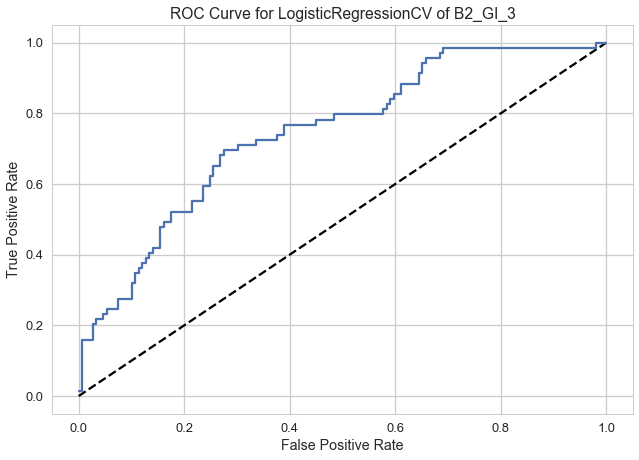

ROC_AUC Score: 0.745452776967


In [73]:
# Fit Logistic Regression with Cross Validation
lgr=LogisticRegressionCV(scoring='roc_auc').fit(B2_GI_3_Xtrain, y_train_B2_GI_3)
print("training set score: %f" % lgr.score(B2_GI_3_Xtrain, y_train_B2_GI_3))
print('\n'"test set score: %f" % lgr.score(B2_GI_3_Xtest, y_test_B2_GI_3))

# calculated predicted class label per sample: pred_lgr
pred_lgr = lgr.predict(B2_GI_3_Xtest)

# print the confusion matrix 
print('\n''Confusion matrix:''\n', metrics.confusion_matrix(y_test_B2_GI_3, pred_lgr))

# calculate predicted probabilities for X_test Logistic Regression model
y_pred_prob_lgr = lgr.predict_proba(B2_GI_3_Xtest)[:, 1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test_B2_GI_3, y_pred_prob_lgr)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for LogisticRegressionCV of B2_GI_3')
plt.show()

# calculate AUC for LogisticRegressionCV classifier
print('ROC_AUC Score:', metrics.roc_auc_score(y_test_B2_GI_3, y_pred_prob_lgr))

### Run Random Forest on B2_GI_3

training set score: 0.975689

test set score: 0.697248

Confusion matrix:
 [[130  19]
 [ 42  27]]


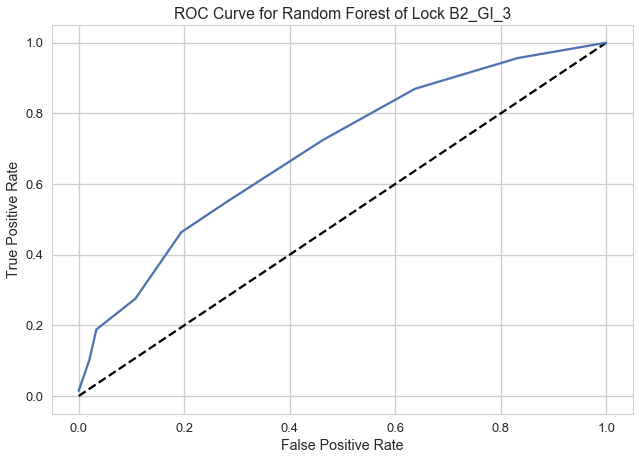

ROC_AUC Score 0.693220503842


In [74]:
# Instantiate and fit the random forest model. 
rf = RandomForestClassifier().fit(B2_GI_3_Xtrain, y_train_B2_GI_3) 

## And score it on your testing data.
print("training set score: %f" % rf.score(B2_GI_3_Xtrain, y_train_B2_GI_3))
print('\n'"test set score: %f" % rf.score(B2_GI_3_Xtest, y_test_B2_GI_3))

# calculated predicted class label per sample: pred_lgr
pred_lgr = lgr.predict(B2_GI_3_Xtest)

# print the confusion matrix 
print('\n''Confusion matrix:''\n', metrics.confusion_matrix(y_test_B2_GI_3, pred_lgr))

# calculate predicted probabilities
y_pred_prob_rf = rf.predict_proba(B2_GI_3_Xtest)[:, 1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test_B2_GI_3, y_pred_prob_rf)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest of Lock B2_GI_3')
plt.show()

# calculate AUC for randomforest model
print('ROC_AUC Score', metrics.roc_auc_score(y_test_B2_GI_3, y_pred_prob_rf))

In [75]:
# create an instance of the grid search by passing the classifier, parameters 
# and n_jobs=-1 which tells to use multiple cores from user machine.
gs_rf = GridSearchCV(RandomForestClassifier(), params, scoring='roc_auc', n_jobs=-1)
gs_rf = gs_rf.fit(B2_GI_3_Xtrain, y_train_B2_GI_3) 

# View the best AUC score
print('Best score:', gs_rf.best_score_) 

# Get best parameters
print('\n''Best parameters:', gs_rf.best_params_)

# Explore feature importances
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = B2_GI_3_Xtrain.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

# Print sorted list of feature importances
feature_importances

Best score: 0.759298194594

Best parameters: {'max_features': 35, 'min_samples_leaf': 6, 'min_samples_split': 8}


,importance
AWND,0.117310
TMIN,0.110940
TAVG,0.105461
TMAX,0.105054
WSF5,0.097265
WSF2,0.092989
year_2014,0.072522
PRCP,0.062347
unplan_max_stop,0.049297
weekday,0.022111


## Run Logistic Regression and Random Forest Models on  training and testing data for lock B2_GI_4

training set score: 0.729529

test set score: 0.711111

Confusion matrix:
 [[218  34]
 [ 83  70]]


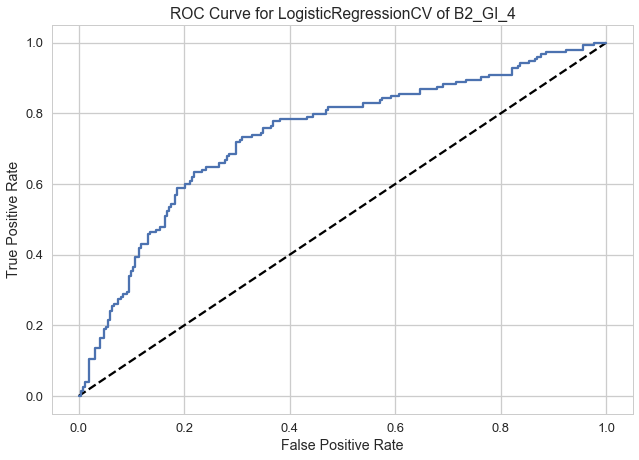

ROC_AUC Score: 0.737550575786


In [76]:
# Fit Logistic Regression with Cross Validation
lgr=LogisticRegressionCV(scoring='roc_auc').fit(B2_GI_4_Xtrain, y_train_B2_GI_4)
print("training set score: %f" % lgr.score(B2_GI_4_Xtrain, y_train_B2_GI_4))
print('\n'"test set score: %f" % lgr.score(B2_GI_4_Xtest, y_test_B2_GI_4))

# calculated predicted class label per sample: pred_lgr
pred_lgr = lgr.predict(B2_GI_4_Xtest)

# print the confusion matrix 
print('\n''Confusion matrix:''\n', metrics.confusion_matrix(y_test_B2_GI_4, pred_lgr))

# calculate predicted probabilities for X_test Logistic Regression model
y_pred_prob_lgr = lgr.predict_proba(B2_GI_4_Xtest)[:, 1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test_B2_GI_4, y_pred_prob_lgr)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for LogisticRegressionCV of B2_GI_4')
plt.show()

# calculate AUC for LogisticRegressionCV classifier
print('ROC_AUC Score:', metrics.roc_auc_score(y_test_B2_GI_4, y_pred_prob_lgr))

### Random Forest Model of B2_GI_4

training set score: 0.978495

test set score: 0.740741

Confusion matrix:
 [[218  34]
 [ 83  70]]


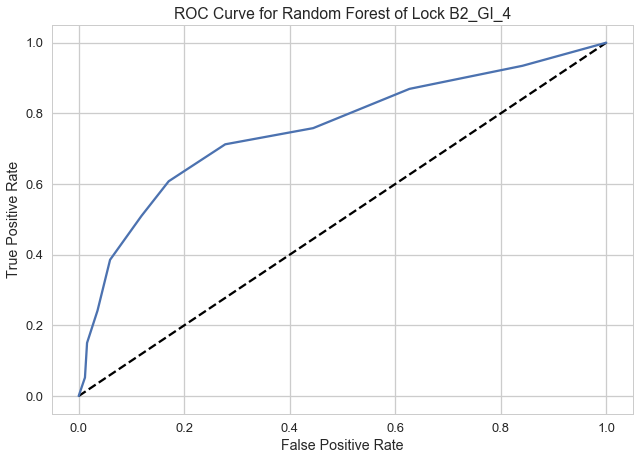

ROC_AUC Score 0.756185807656


In [77]:
# Instantiate and fit the random forest model. 
rf = RandomForestClassifier().fit(B2_GI_4_Xtrain, y_train_B2_GI_4) 

## And score it on your testing data.
print("training set score: %f" % rf.score(B2_GI_4_Xtrain, y_train_B2_GI_4))
print('\n'"test set score: %f" % rf.score(B2_GI_4_Xtest, y_test_B2_GI_4))

# calculated predicted class label per sample: pred_lgr
pred_lgr = lgr.predict(B2_GI_4_Xtest)

# print the confusion matrix 
print('\n''Confusion matrix:''\n', metrics.confusion_matrix(y_test_B2_GI_4, pred_lgr))

# calculate predicted probabilities
y_pred_prob_rf = rf.predict_proba(B2_GI_4_Xtest)[:, 1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test_B2_GI_4, y_pred_prob_rf)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest of Lock B2_GI_4')
plt.show()

# calculate AUC for randomforest model
print('ROC_AUC Score', metrics.roc_auc_score(y_test_B2_GI_4, y_pred_prob_rf))

### Perform Grid Search to tune hyperparameters for Random Forest

In [78]:
# create an instance of the grid search by passing the classifier, parameters 
# and n_jobs=-1 which tells to use multiple cores from user machine.
gs_rf = GridSearchCV(RandomForestClassifier(), params, scoring='roc_auc', n_jobs=-1)
gs_rf = gs_rf.fit(B2_GI_4_Xtrain, y_train_B2_GI_4) 

# View the best AUC score
print('Best score:', gs_rf.best_score_) 

# Get best parameters
print('\n''Best parameters:', gs_rf.best_params_)

# Explore feature importances
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = B2_GI_4_Xtrain.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

# Print sorted list of feature importances
feature_importances

Best score: 0.795741438049

Best parameters: {'max_features': 20, 'min_samples_leaf': 12, 'min_samples_split': 7}


,importance
TMIN,1.175560e-01
TMAX,1.107534e-01
AWND,1.076202e-01
TAVG,9.554998e-02
WSF5,9.468796e-02
WSF2,9.310658e-02
year_2015,6.317873e-02
season_spring,5.573031e-02
PRCP,4.824976e-02
year_2016,3.498090e-02


### Run Logistic Regression & Random Forest Models on Lock B2_GI_77

training set score: 0.709848

test set score: 0.691111

Confusion matrix:
 [[159  75]
 [ 64 152]]


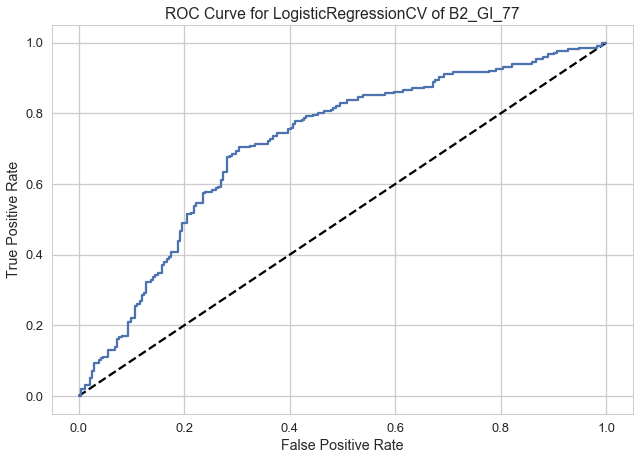

ROC_AUC Score: 0.712784900285


In [79]:
# Fit Logistic Regression with Cross Validation
lgr=LogisticRegressionCV(scoring='roc_auc').fit(B2_GI_77_Xtrain, y_train_B2_GI_77)
print("training set score: %f" % lgr.score(B2_GI_77_Xtrain, y_train_B2_GI_77))
print('\n'"test set score: %f" % lgr.score(B2_GI_77_Xtest, y_test_B2_GI_77))

# calculated predicted class label per sample: pred_lgr
pred_lgr = lgr.predict(B2_GI_77_Xtest)

# print the confusion matrix 
print('\n''Confusion matrix:''\n', metrics.confusion_matrix(y_test_B2_GI_77, pred_lgr))

# calculate predicted probabilities for X_test Logistic Regression model
y_pred_prob_lgr = lgr.predict_proba(B2_GI_77_Xtest)[:, 1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test_B2_GI_77, y_pred_prob_lgr)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for LogisticRegressionCV of B2_GI_77')
plt.show()

# calculate AUC for LogisticRegressionCV classifier
print('ROC_AUC Score:', metrics.roc_auc_score(y_test_B2_GI_77, y_pred_prob_lgr))

training set score: 0.976515

test set score: 0.635556

Confusion matrix:
 [[159  75]
 [ 64 152]]


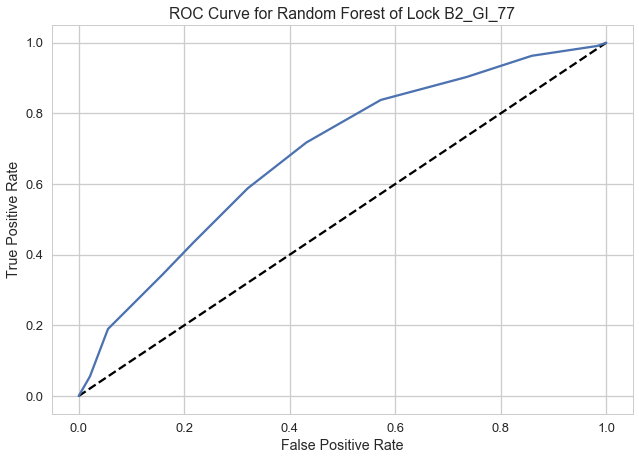

ROC_AUC Score 0.685076369104


In [80]:
# Instantiate and fit the random forest model. 
rf = RandomForestClassifier().fit(B2_GI_77_Xtrain, y_train_B2_GI_77) 

## And score it on your testing data.
print("training set score: %f" % rf.score(B2_GI_77_Xtrain, y_train_B2_GI_77))
print('\n'"test set score: %f" % rf.score(B2_GI_77_Xtest, y_test_B2_GI_77))

# calculated predicted class label per sample: pred_lgr
pred_lgr = lgr.predict(B2_GI_77_Xtest)

# print the confusion matrix 
print('\n''Confusion matrix:''\n', metrics.confusion_matrix(y_test_B2_GI_77, pred_lgr))

# calculate predicted probabilities
y_pred_prob_rf = rf.predict_proba(B2_GI_77_Xtest)[:, 1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test_B2_GI_77, y_pred_prob_rf)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest of Lock B2_GI_77')
plt.show()

# calculate AUC for randomforest model
print('ROC_AUC Score', metrics.roc_auc_score(y_test_B2_GI_77, y_pred_prob_rf))

In [81]:
# create an instance of the grid search by passing the classifier, parameters 
# and n_jobs=-1 which tells to use multiple cores from user machine.
gs_rf = GridSearchCV(RandomForestClassifier(), params, scoring='roc_auc', n_jobs=-1)
gs_rf = gs_rf.fit(B2_GI_77_Xtrain, y_train_B2_GI_77) 

# View the best AUC score
print('Best score:', gs_rf.best_score_) 

# Get best parameters
print('\n''Best parameters:', gs_rf.best_params_)

# Explore feature importances
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = B2_GI_77_Xtrain.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

# Print sorted list of feature importances
feature_importances

Best score: 0.730511183209

Best parameters: {'max_features': 12, 'min_samples_leaf': 22, 'min_samples_split': 8}


,importance
AWND,0.131631
TMIN,0.122229
TMAX,0.115045
WSF5,0.108996
WSF2,0.087686
lockage_O,0.081257
lockage_S,0.070358
PRCP,0.064265
night,0.032834
year_2015,0.023934


### Models for individual lock B3_MI_27

training set score: 0.663659

test set score: 0.619048

Confusion matrix:
 [[253  20]
 [148  20]]


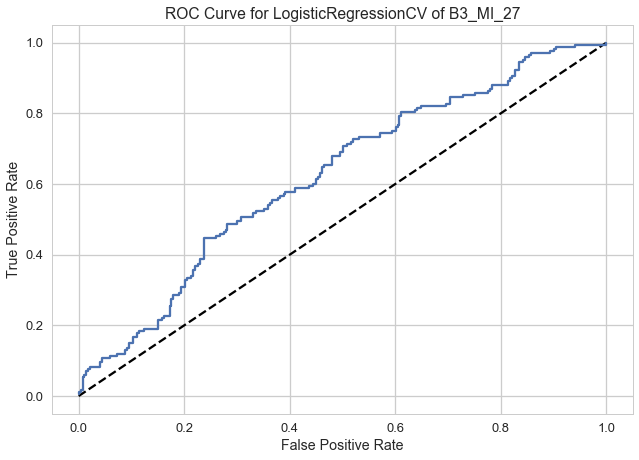

ROC_AUC Score: 0.622492586778


In [82]:
# Fit Logistic Regression with Cross Validation
lgr=LogisticRegressionCV(scoring='roc_auc').fit(B3_MI_27_Xtrain, y_train_B3_MI_27)
print("training set score: %f" % lgr.score(B3_MI_27_Xtrain, y_train_B3_MI_27))
print('\n'"test set score: %f" % lgr.score(B3_MI_27_Xtest, y_test_B3_MI_27))

# calculated predicted class label per sample: pred_lgr
pred_lgr = lgr.predict(B3_MI_27_Xtest)

# print the confusion matrix 
print('\n''Confusion matrix:''\n', metrics.confusion_matrix(y_test_B3_MI_27, pred_lgr))

# calculate predicted probabilities for X_test Logistic Regression model
y_pred_prob_lgr = lgr.predict_proba(B3_MI_27_Xtest)[:, 1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test_B3_MI_27, y_pred_prob_lgr)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for LogisticRegressionCV of B3_MI_27')
plt.show()

# calculate AUC for LogisticRegressionCV classifier
print('ROC_AUC Score:', metrics.roc_auc_score(y_test_B3_MI_27, y_pred_prob_lgr))

training set score: 0.976210

test set score: 0.591837

Confusion matrix:
 [[253  20]
 [148  20]]


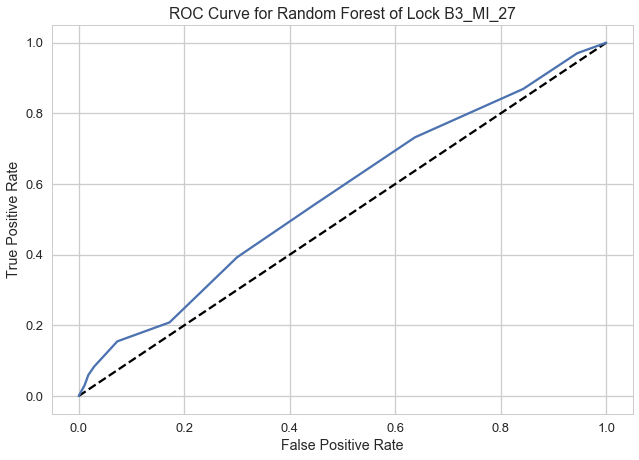

ROC_AUC Score 0.565454386883


In [83]:
# Instantiate and fit the random forest model. 
rf = RandomForestClassifier().fit(B3_MI_27_Xtrain, y_train_B3_MI_27) 

## And score it on your testing data.
print("training set score: %f" % rf.score(B3_MI_27_Xtrain, y_train_B3_MI_27))
print('\n'"test set score: %f" % rf.score(B3_MI_27_Xtest, y_test_B3_MI_27))

# calculated predicted class label per sample: pred_lgr
pred_lgr = lgr.predict(B3_MI_27_Xtest)

# print the confusion matrix 
print('\n''Confusion matrix:''\n', metrics.confusion_matrix(y_test_B3_MI_27, pred_lgr))

# calculate predicted probabilities
y_pred_prob_rf = rf.predict_proba(B3_MI_27_Xtest)[:, 1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test_B3_MI_27, y_pred_prob_rf)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest of Lock B3_MI_27')
plt.show()

# calculate AUC for randomforest model
print('ROC_AUC Score', metrics.roc_auc_score(y_test_B3_MI_27, y_pred_prob_rf))

In [84]:
# create an instance of the grid search by passing the classifier, parameters 
# and n_jobs=-1 which tells to use multiple cores from user machine.
gs_rf = GridSearchCV(RandomForestClassifier(), params, scoring='roc_auc', n_jobs=-1)
gs_rf = gs_rf.fit(B3_MI_27_Xtrain, y_train_B3_MI_27) 

# View the best AUC score
print('Best score:', gs_rf.best_score_) 

# Get best parameters
print('\n''Best parameters:', gs_rf.best_params_)

# Explore feature importances
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = B3_MI_27_Xtrain.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

# Print sorted list of feature importances
feature_importances

Best score: 0.611261357088

Best parameters: {'max_features': 12, 'min_samples_leaf': 10, 'min_samples_split': 10}


,importance
TAVG,0.126130
TMIN,0.124681
AWND,0.121685
TMAX,0.119039
WSF2,0.111051
WSF5,0.093998
PRCP,0.060366
lockage_S,0.027760
WType,0.024896
weekday,0.022765


### Fit models for individual lock G3_WS_1

training set score: 0.690832

test set score: 0.674194

Confusion matrix:
 [[ 90  55]
 [ 46 119]]


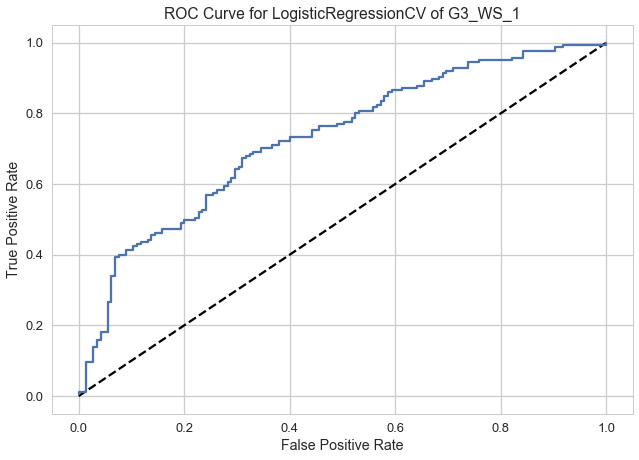

ROC_AUC Score: 0.728317659352


In [85]:
# Fit Logistic Regression with Cross Validation
lgr=LogisticRegressionCV(scoring='roc_auc').fit(G3_WS_1_Xtrain, y_train_G3_WS_1)
print("training set score: %f" % lgr.score(G3_WS_1_Xtrain, y_train_G3_WS_1))
print('\n'"test set score: %f" % lgr.score(G3_WS_1_Xtest, y_test_G3_WS_1))

# calculated predicted class label per sample: pred_lgr
pred_lgr = lgr.predict(G3_WS_1_Xtest)

# print the confusion matrix 
print('\n''Confusion matrix:''\n', metrics.confusion_matrix(y_test_G3_WS_1, pred_lgr))

# calculate predicted probabilities for X_test Logistic Regression model
y_pred_prob_lgr = lgr.predict_proba(G3_WS_1_Xtest)[:, 1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test_G3_WS_1, y_pred_prob_lgr)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for LogisticRegressionCV of G3_WS_1')
plt.show()

# calculate AUC for LogisticRegressionCV classifier
print('ROC_AUC Score:', metrics.roc_auc_score(y_test_G3_WS_1, y_pred_prob_lgr))

training set score: 0.981876

test set score: 0.583871

Confusion matrix:
 [[ 90  55]
 [ 46 119]]


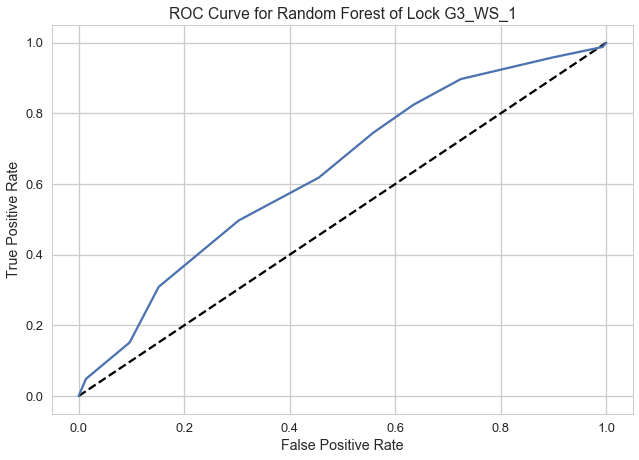

ROC_AUC Score 0.634942528736


In [86]:
# Instantiate and fit the random forest model. 
rf = RandomForestClassifier().fit(G3_WS_1_Xtrain, y_train_G3_WS_1) 

## And score it on your testing data.
print("training set score: %f" % rf.score(G3_WS_1_Xtrain, y_train_G3_WS_1))
print('\n'"test set score: %f" % rf.score(G3_WS_1_Xtest, y_test_G3_WS_1))

# calculated predicted class label per sample: pred_lgr
pred_lgr = lgr.predict(G3_WS_1_Xtest)

# print the confusion matrix 
print('\n''Confusion matrix:''\n', metrics.confusion_matrix(y_test_G3_WS_1, pred_lgr))

# calculate predicted probabilities
y_pred_prob_rf = rf.predict_proba(G3_WS_1_Xtest)[:, 1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test_G3_WS_1, y_pred_prob_rf)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest of Lock G3_WS_1')
plt.show()

# calculate AUC for randomforest model
print('ROC_AUC Score', metrics.roc_auc_score(y_test_G3_WS_1, y_pred_prob_rf))

In [87]:
# create an instance of the grid search by passing the classifier, parameters 
# and n_jobs=-1 which tells to use multiple cores from user machine.
gs_rf = GridSearchCV(RandomForestClassifier(), params, scoring='roc_auc', n_jobs=-1)
gs_rf = gs_rf.fit(G3_WS_1_Xtrain, y_train_G3_WS_1) 

# View the best AUC score
print('Best score:', gs_rf.best_score_) 

# Get best parameters
print('\n''Best parameters:', gs_rf.best_params_)

# Explore feature importances
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = G3_WS_1_Xtrain.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

# Print sorted list of feature importances
feature_importances

Best score: 0.722862175015

Best parameters: {'max_features': 20, 'min_samples_leaf': 22, 'min_samples_split': 12}


,importance
TMAX,0.124339
TMIN,0.123743
AWND,0.118931
TAVG,0.107073
WSF2,0.083106
WSF5,0.076240
PRCP,0.064625
VFT_T,0.038433
VFT_R,0.027705
weekday,0.023207


### Fit models for individual lock H2_OH_76

training set score: 0.736503

test set score: 0.732500

Confusion matrix:
 [[288   3]
 [104   5]]


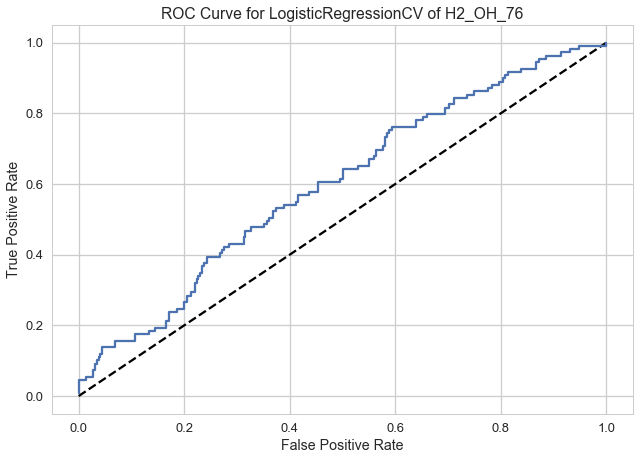

ROC_AUC Score: 0.598726315458


In [88]:
# Fit Logistic Regression with Cross Validation
lgr=LogisticRegressionCV(scoring='roc_auc').fit(H2_OH_76_Xtrain, y_train_H2_OH_76)
print("training set score: %f" % lgr.score(H2_OH_76_Xtrain, y_train_H2_OH_76))
print('\n'"test set score: %f" % lgr.score(H2_OH_76_Xtest, y_test_H2_OH_76))

# calculated predicted class label per sample: pred_lgr
pred_lgr = lgr.predict(H2_OH_76_Xtest)

# print the confusion matrix 
print('\n''Confusion matrix:''\n', metrics.confusion_matrix(y_test_H2_OH_76, pred_lgr))

# calculate predicted probabilities for X_test Logistic Regression model
y_pred_prob_lgr = lgr.predict_proba(H2_OH_76_Xtest)[:, 1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test_H2_OH_76, y_pred_prob_lgr)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for LogisticRegressionCV of H2_OH_76')
plt.show()

# calculate AUC for LogisticRegressionCV classifier
print('ROC_AUC Score:', metrics.roc_auc_score(y_test_H2_OH_76, y_pred_prob_lgr))

training set score: 0.973409

test set score: 0.697500

Confusion matrix:
 [[288   3]
 [104   5]]


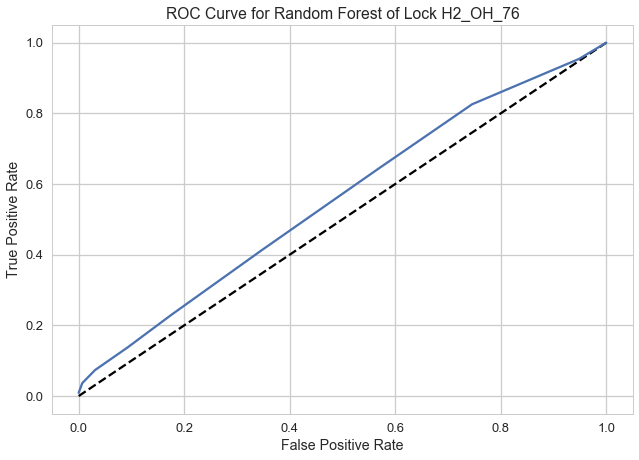

ROC_AUC Score 0.556275418519


In [89]:
# Instantiate and fit the random forest model. 
rf = RandomForestClassifier().fit(H2_OH_76_Xtrain, y_train_H2_OH_76) 

## And score it on your testing data.
print("training set score: %f" % rf.score(H2_OH_76_Xtrain, y_train_H2_OH_76))
print('\n'"test set score: %f" % rf.score(H2_OH_76_Xtest, y_test_H2_OH_76))

# calculated predicted class label per sample: pred_lgr
pred_lgr = lgr.predict(H2_OH_76_Xtest)

# print the confusion matrix 
print('\n''Confusion matrix:''\n', metrics.confusion_matrix(y_test_H2_OH_76, pred_lgr))

# calculate predicted probabilities
y_pred_prob_rf = rf.predict_proba(H2_OH_76_Xtest)[:, 1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test_H2_OH_76, y_pred_prob_rf)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest of Lock H2_OH_76')
plt.show()

# calculate AUC for randomforest model
print('ROC_AUC Score', metrics.roc_auc_score(y_test_H2_OH_76, y_pred_prob_rf))

In [90]:
# create an instance of the grid search by passing the classifier, parameters 
# and n_jobs=-1 which tells to use multiple cores from user machine.
gs_rf = GridSearchCV(RandomForestClassifier(), params, scoring='roc_auc', n_jobs=-1)
gs_rf = gs_rf.fit(H2_OH_76_Xtrain, y_train_H2_OH_76) 

# View the best AUC score
print('Best score:', gs_rf.best_score_) 

# Get best parameters
print('\n''Best parameters:', gs_rf.best_params_)

# Explore feature importances
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = H2_OH_76_Xtrain.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

# Print sorted list of feature importances
feature_importances

Best score: 0.638929154748

Best parameters: {'max_features': 20, 'min_samples_leaf': 10, 'min_samples_split': 17}


,importance
AWND,0.118105
TAVG,0.113608
TMAX,0.110846
TMIN,0.109806
WSF5,0.098768
WSF2,0.091841
PRCP,0.065588
unplan_max_stop,0.057104
night,0.031095
weekday,0.023923


### Fit models for individual lock M3_GI_11

training set score: 0.643991

test set score: 0.578164

Confusion matrix:
 [[ 67  88]
 [ 82 166]]


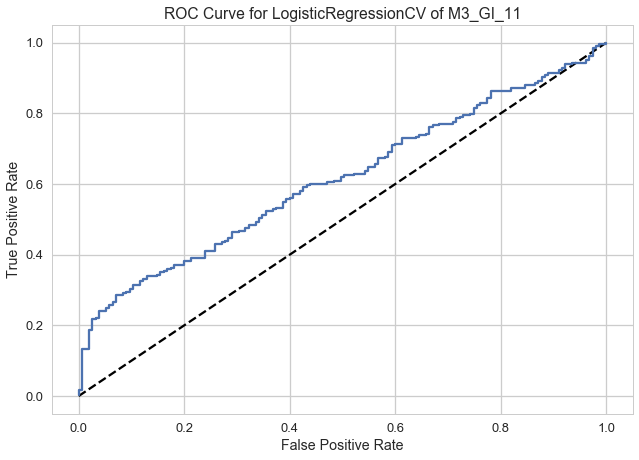

ROC_AUC Score: 0.612903225806


In [91]:
# Fit Logistic Regression with Cross Validation
lgr=LogisticRegressionCV(scoring='roc_auc').fit(M3_GI_11_Xtrain, y_train_M3_GI_11)
print("training set score: %f" % lgr.score(M3_GI_11_Xtrain, y_train_M3_GI_11))
print('\n'"test set score: %f" % lgr.score(M3_GI_11_Xtest, y_test_M3_GI_11))

# calculated predicted class label per sample: pred_lgr
pred_lgr = lgr.predict(M3_GI_11_Xtest)

# print the confusion matrix 
print('\n''Confusion matrix:''\n', metrics.confusion_matrix(y_test_M3_GI_11, pred_lgr))

# calculate predicted probabilities for X_test Logistic Regression model
y_pred_prob_lgr = lgr.predict_proba(M3_GI_11_Xtest)[:, 1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test_M3_GI_11, y_pred_prob_lgr)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for LogisticRegressionCV of M3_GI_11')
plt.show()

# calculate AUC for LogisticRegressionCV classifier
print('ROC_AUC Score:', metrics.roc_auc_score(y_test_M3_GI_11, y_pred_prob_lgr))

training set score: 0.983371

test set score: 0.573201

Confusion matrix:
 [[ 67  88]
 [ 82 166]]


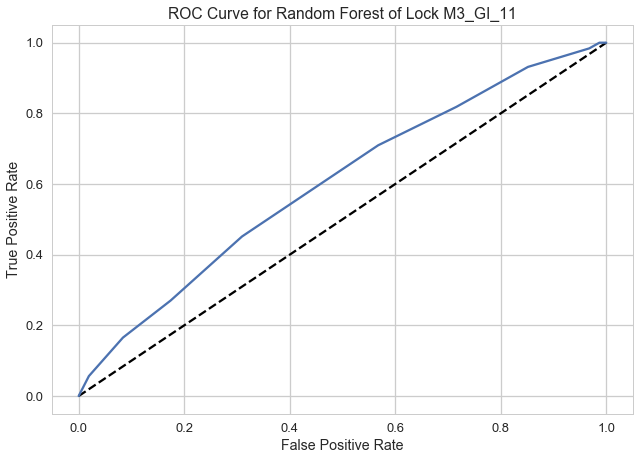

ROC_AUC Score 0.601352757544


In [92]:
# Instantiate and fit the random forest model. 
rf = RandomForestClassifier().fit(M3_GI_11_Xtrain, y_train_M3_GI_11) 

## And score it on your testing data.
print("training set score: %f" % rf.score(M3_GI_11_Xtrain, y_train_M3_GI_11))
print('\n'"test set score: %f" % rf.score(M3_GI_11_Xtest, y_test_M3_GI_11))

# calculated predicted class label per sample: pred_lgr
pred_lgr = lgr.predict(M3_GI_11_Xtest)

# print the confusion matrix 
print('\n''Confusion matrix:''\n', metrics.confusion_matrix(y_test_M3_GI_11, pred_lgr))

# calculate predicted probabilities
y_pred_prob_rf = rf.predict_proba(M3_GI_11_Xtest)[:, 1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test_M3_GI_11, y_pred_prob_rf)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest of Lock M3_GI_11')
plt.show()

# calculate AUC for randomforest model
print('ROC_AUC Score', metrics.roc_auc_score(y_test_M3_GI_11, y_pred_prob_rf))

In [93]:
# create an instance of the grid search by passing the classifier, parameters 
# and n_jobs=-1 which tells to use multiple cores from user machine.
gs_rf = GridSearchCV(RandomForestClassifier(), params, scoring='roc_auc', n_jobs=-1)
gs_rf = gs_rf.fit(M3_GI_11_Xtrain, y_train_M3_GI_11) 

# View the best AUC score
print('Best score:', gs_rf.best_score_) 

# Get best parameters
print('\n''Best parameters:', gs_rf.best_params_)

# Explore feature importances
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = M3_GI_11_Xtrain.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

# Print sorted list of feature importances
feature_importances

Best score: 0.674206588299

Best parameters: {'max_features': 15, 'min_samples_leaf': 22, 'min_samples_split': 7}


,importance
AWND,0.147604
TMIN,0.142576
TMAX,0.141149
WSF5,0.124646
WSF2,0.104810
year_2017,0.056360
PRCP,0.053932
weekday,0.033055
night,0.027596
season_spring,0.021969


### Fit models for individual lock M3_GI_12

training set score: 0.627651

test set score: 0.608696

Confusion matrix:
 [[120  94]
 [ 77 146]]


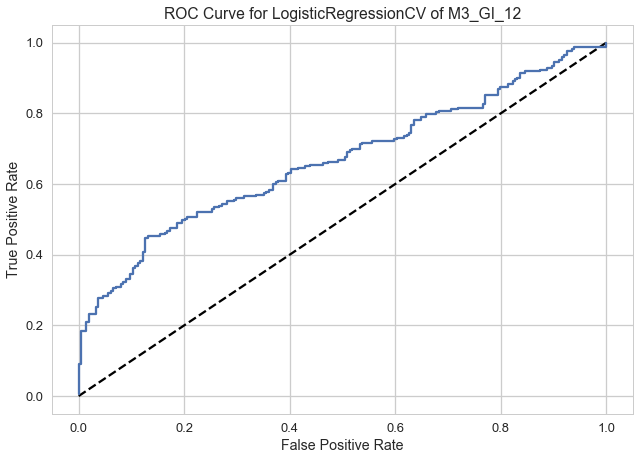

ROC_AUC Score: 0.667029881396


In [94]:
# Fit Logistic Regression with Cross Validation
lgr=LogisticRegressionCV(scoring='roc_auc').fit(M3_GI_12_Xtrain, y_train_M3_GI_12)
print("training set score: %f" % lgr.score(M3_GI_12_Xtrain, y_train_M3_GI_12))
print('\n'"test set score: %f" % lgr.score(M3_GI_12_Xtest, y_test_M3_GI_12))

# calculated predicted class label per sample: pred_lgr
pred_lgr = lgr.predict(M3_GI_12_Xtest)

# print the confusion matrix 
print('\n''Confusion matrix:''\n', metrics.confusion_matrix(y_test_M3_GI_12, pred_lgr))

# calculate predicted probabilities for X_test Logistic Regression model
y_pred_prob_lgr = lgr.predict_proba(M3_GI_12_Xtest)[:, 1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test_M3_GI_12, y_pred_prob_lgr)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for LogisticRegressionCV of M3_GI_12')
plt.show()

# calculate AUC for LogisticRegressionCV classifier
print('ROC_AUC Score:', metrics.roc_auc_score(y_test_M3_GI_12, y_pred_prob_lgr))

training set score: 0.986646

test set score: 0.569794

Confusion matrix:
 [[120  94]
 [ 77 146]]


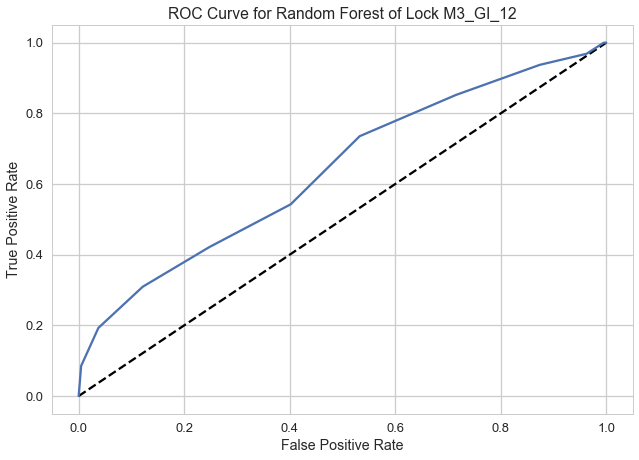

ROC_AUC Score 0.638185742425


In [95]:
# Instantiate and fit the random forest model. 
rf = RandomForestClassifier().fit(M3_GI_12_Xtrain, y_train_M3_GI_12) 

## And score it on your testing data.
print("training set score: %f" % rf.score(M3_GI_12_Xtrain, y_train_M3_GI_12))
print('\n'"test set score: %f" % rf.score(M3_GI_12_Xtest, y_test_M3_GI_12))

# calculated predicted class label per sample: pred_lgr
pred_lgr = lgr.predict(M3_GI_12_Xtest)

# print the confusion matrix 
print('\n''Confusion matrix:''\n', metrics.confusion_matrix(y_test_M3_GI_12, pred_lgr))

# calculate predicted probabilities
y_pred_prob_rf = rf.predict_proba(M3_GI_12_Xtest)[:, 1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test_M3_GI_12, y_pred_prob_rf)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest of Lock M3_GI_12')
plt.show()

# calculate AUC for randomforest model
print('ROC_AUC Score', metrics.roc_auc_score(y_test_M3_GI_12, y_pred_prob_rf))

In [96]:
# create an instance of the grid search by passing the classifier, parameters 
# and n_jobs=-1 which tells to use multiple cores from user machine.
gs_rf = GridSearchCV(RandomForestClassifier(), params, scoring='roc_auc', n_jobs=-1)
gs_rf = gs_rf.fit(M3_GI_12_Xtrain, y_train_M3_GI_12) 

# View the best AUC score
print('Best score:', gs_rf.best_score_) 

# Get best parameters
print('\n''Best parameters:', gs_rf.best_params_)

# Explore feature importances
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = M3_GI_12_Xtrain.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

# Print sorted list of feature importances
feature_importances

Best score: 0.651279045393

Best parameters: {'max_features': 24, 'min_samples_leaf': 10, 'min_samples_split': 8}


,importance
AWND,0.151029
TMIN,0.147574
TMAX,0.141332
WSF5,0.125896
WSF2,0.112865
year_2017,0.056511
PRCP,0.044737
night,0.032025
weekday,0.028516
WType,0.026644


### Fit models for individual lock M3_GI_14

training set score: 0.717447

test set score: 0.719697

Confusion matrix:
 [[160  37]
 [ 74 125]]


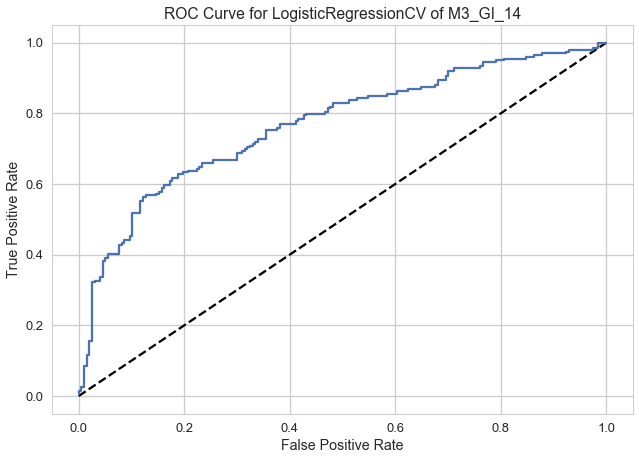

ROC_AUC Score: 0.76731372599


In [97]:
# Fit Logistic Regression with Cross Validation
lgr=LogisticRegressionCV(scoring='roc_auc').fit(M3_GI_14_Xtrain, y_train_M3_GI_14)
print("training set score: %f" % lgr.score(M3_GI_14_Xtrain, y_train_M3_GI_14))
print('\n'"test set score: %f" % lgr.score(M3_GI_14_Xtest, y_test_M3_GI_14))

# calculated predicted class label per sample: pred_lgr
pred_lgr = lgr.predict(M3_GI_14_Xtest)

# print the confusion matrix 
print('\n''Confusion matrix:''\n', metrics.confusion_matrix(y_test_M3_GI_14, pred_lgr))

# calculate predicted probabilities for X_test Logistic Regression model
y_pred_prob_lgr = lgr.predict_proba(M3_GI_14_Xtest)[:, 1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test_M3_GI_14, y_pred_prob_lgr)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for LogisticRegressionCV of M3_GI_14')
plt.show()

# calculate AUC for LogisticRegressionCV classifier
print('ROC_AUC Score:', metrics.roc_auc_score(y_test_M3_GI_14, y_pred_prob_lgr))

training set score: 0.984681

test set score: 0.714646

Confusion matrix:
 [[160  37]
 [ 74 125]]


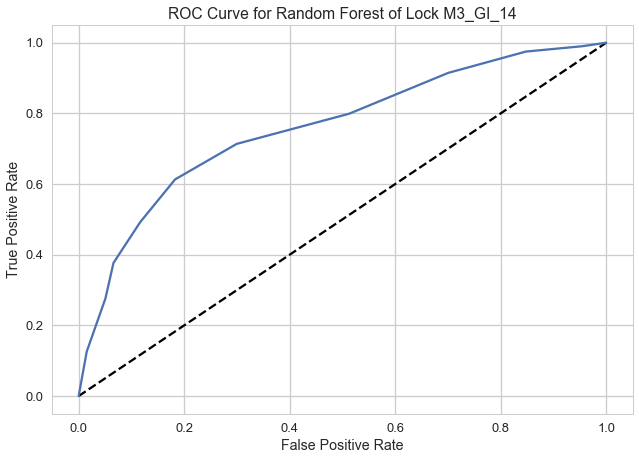

ROC_AUC Score 0.76046476035


In [98]:
# Instantiate and fit the random forest model. 
rf = RandomForestClassifier().fit(M3_GI_14_Xtrain, y_train_M3_GI_14) 

## And score it on your testing data.
print("training set score: %f" % rf.score(M3_GI_14_Xtrain, y_train_M3_GI_14))
print('\n'"test set score: %f" % rf.score(M3_GI_14_Xtest, y_test_M3_GI_14))

# calculated predicted class label per sample: pred_lgr
pred_lgr = lgr.predict(M3_GI_14_Xtest)

# print the confusion matrix 
print('\n''Confusion matrix:''\n', metrics.confusion_matrix(y_test_M3_GI_14, pred_lgr))

# calculate predicted probabilities
y_pred_prob_rf = rf.predict_proba(M3_GI_14_Xtest)[:, 1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test_M3_GI_14, y_pred_prob_rf)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest of Lock M3_GI_14')
plt.show()

# calculate AUC for randomforest model
print('ROC_AUC Score', metrics.roc_auc_score(y_test_M3_GI_14, y_pred_prob_rf))

In [99]:
# create an instance of the grid search by passing the classifier, parameters 
# and n_jobs=-1 which tells to use multiple cores from user machine.
gs_rf = GridSearchCV(RandomForestClassifier(), params, scoring='roc_auc', n_jobs=-1)
gs_rf = gs_rf.fit(M3_GI_14_Xtrain, y_train_M3_GI_14) 

# View the best AUC score
print('Best score:', gs_rf.best_score_) 

# Get best parameters
print('\n''Best parameters:', gs_rf.best_params_)

# Explore feature importances
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = M3_GI_14_Xtrain.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

# Print sorted list of feature importances
feature_importances

Best score: 0.76487674193

Best parameters: {'max_features': 12, 'min_samples_leaf': 22, 'min_samples_split': 7}


,importance
AWND,0.130120
TMIN,0.127552
TMAX,0.122134
WSF5,0.118414
WSF2,0.110198
year_2016,0.105876
PRCP,0.052995
year_2014,0.036896
year_2017,0.033271
weekday,0.029690
